# CGC and fishy genes enrichment analysis

* Min processed across methods
* Not normalized
* Shared genes 

In [1]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn005


In [2]:
import pandas as pd
import math
from matplotlib import pyplot as plt
import os
import numpy as np
import seaborn as sns
from tqdm import tqdm
import warnings
import random
from scipy import stats

## Compute enrichment scores

In [24]:
def processed_by_all(df_pvals):
    """
    Get bolean of vector of genes that are processed by all methods.
    """
    
    not_na = df_pvals.notna().all(1)
    
    return not_na


def enrich_score(vec_labels):
    """
    Compute enrichment score as shown in Martínez-Jiménez et Al. 2020 
    https://www.nature.com/articles/s41568-020-0290-x
    """
    
    target_count = 0
    lst_score = []

    for total_count, bi_label in enumerate(vec_labels):
        target_count += bi_label
        enrich_value = target_count / (total_count + 1)
        lst_score.append(enrich_value)
        
    return np.array(lst_score)


def min_processed_genes(df_pvals, processed_thld=1):
    """
    Define n (n top genes) by integer or equal to the min 
    number of processed genes with p-val < min_score.
    """
                    
    df = df_pvals.copy()
    n = ((df.lt(processed_thld)) & (df.notna())).sum().min()     

    return n


def avg_cut_processed_genes(df, rank_cut, alpha=0.01):
    """
    Get the average number of gemes processed by all the methods.
    """
    
    all_methods_pval = [col for col in df.columns if col.endswith("pval")]
    
    if rank_cut == "processed":
        avg_rank_cut = round(df[all_methods_pval].apply(lambda col: col.notna() & (col != 1)).sum().mean())
        
    elif rank_cut == "significant":
        avg_rank_cut = round(df[all_methods_pval].apply(lambda col: col < alpha).sum().mean())
        
    else:
        raise ValueError("unable to handle the parameter 'rank_cut'. Allowed values are ['min_processed', 'processed', 'significant', int].""")
    
    return avg_rank_cut


def auc(enrich_score_vec):
    """
    Compute AUC of a set ranked enrichment scores 
    as shown in Martínez-Jiménez et Al. 2020 
    https://www.nature.com/articles/s41568-020-0290-x
    """
    
    auc_score = 0
    for i, pi in enumerate(enrich_score_vec):
        score = pi / math.log(i+2, 10)
        auc_score += score
        
    return auc_score


def sort_by_col(df, col):
    """
    Sort by method rank or by annotation to get max score.
    """
    
    if col == "CGC" or col == "Fish":
        ascending=False
    else:
        ascending=True

    return df.copy().sort_values(by = col, ascending=ascending).reset_index(drop = True)


def get_auc(df,
            method, 
            rank_cut, 
            normalize=False, 
            seed=128,
            alpha=0.01,
            min_rank_cut_thld=1):
    """
    Get AUC of the enrichment curve given a the genetable of a method.
    """
   
    if method == "random":
        df_sorted = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_sorted = sort_by_col(df, f"{method}_rank").reset_index(drop=True)
    
    if isinstance(rank_cut, int):
        df_cut_sorted = df_sorted[:rank_cut]
        
    elif isinstance(rank_cut, str):
        
        avg_rank_cut = avg_cut_processed_genes(df_sorted, rank_cut)
        
        if rank_cut == "processed":
            if method == "random":
                df_cut_sorted = df_sorted[:avg_rank_cut] 
            else:
                method_pval = f"{method}_pval"
                df_cut_sorted = df_sorted[(df_sorted[method_pval].notna()) & (df_sorted[method_pval] != 1)]
                
        elif rank_cut == "significant":
            if method == "random":
                avg_rank_cut = avg_cut_processed_genes(df_sorted, rank_cut, alpha=alpha)
                df_cut_sorted = df_sorted[:avg_rank_cut]
            else:
                method_pval = f"{method}_pval"
                df_cut_sorted = df_sorted[df_sorted[method_pval] < alpha]
                
        else:
            raise ValueError("unable to handle the parameter 'rank_cut'. Allowed values are ['min_processed', 'processed', 'significant', int].""")
            
        if method == "random":
            if avg_rank_cut < min_rank_cut_thld:
                return None, None
    
    df_cut_sorted = df_cut_sorted[["CGC", "Fish"]]
    cgc_auc = auc(enrich_score(df_cut_sorted["CGC"]))
    fish_auc = auc(enrich_score(df_cut_sorted["Fish"]))
    
    if not normalize:
        return cgc_auc, fish_auc
    
    else:
        df_max_cgc = sort_by_col(df_cut_sorted, "CGC")
        df_max_fish = sort_by_col(df_cut_sorted, "Fish")
        cgc_max_auc = auc(enrich_score(df_max_cgc["CGC"]))
        fish_max_auc = auc(enrich_score(df_max_fish["Fish"]))
        
        if cgc_max_auc == 0:
            cgc_auc_norm = np.nan
        else:
            cgc_auc_norm = cgc_auc / cgc_max_auc
        if fish_max_auc == 0:
            fish_auc_norm = np.nan
        else:
            fish_auc_norm = fish_auc / fish_max_auc

        return cgc_auc_norm, fish_auc_norm
    
    
def get_auc_cohort(df_cohort, 
                   lst_methods, 
                   normalize=False, 
                   seed=128, 
                   min_rank_cut_thld=1, 
                   processed_thld=1,
                   rank_cut="min_processed",
                   alpha=0.01,
                   rnd_iter=25):

    """
    Get CGC and Fish enrichment AUC for each method.
    """

    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    min_processed = min_processed_genes(df_cohort[col_pvals], processed_thld=processed_thld)
    print("\n\n")
    print(min_processed)
    display(df_cohort)
    
    if isinstance(rank_cut, str):
        if rank_cut == "min_processed":
            rank_cut = min_processed
    elif isinstance(rank_cut, int):
        if rank_cut < min_processed:
            rank_cut = min_processed

    lst_cols = ["Rank_cut"]
    lst_aucs = [rank_cut]
    
    if isinstance(rank_cut, int):
        if rank_cut < min_rank_cut_thld:
            return 
    
    for method in lst_methods:
        
        if method == "random":
            
            rnd_cgc_lst = []
            rnd_fish_lst = []

            # Generate a list of random integers
            random.seed(seed)
            lst_seeds = [random.randint(1, 1000) for _ in range(rnd_iter)]
            
            for i in range(rnd_iter):
                
                cgc_auc, fish_auc = get_auc(df_cohort, 
                                            method, 
                                            rank_cut=rank_cut, 
                                            normalize=normalize, 
                                            seed=lst_seeds[i], 
                                            min_rank_cut_thld=min_rank_cut_thld,
                                            alpha=alpha)
                
                # AUC scores will be None if the cut thld is not met
                if cgc_auc is None or fish_auc is None:
                    return
                
                else:
                    rnd_cgc_lst.append(cgc_auc)
                    rnd_fish_lst.append(fish_auc)                    
                    
            # Append mean and CI
            cgc_auc_mean, cgc_auc_ci_low, cgc_auc_ci_up = get_mean_ci(rnd_cgc_lst)
            fish_auc_mean, fish_auc_ci_low, fish_auc_ci_up = get_mean_ci(rnd_fish_lst)
            [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC", "Fish"]]
            [lst_aucs.append(value) for value in [cgc_auc_mean, fish_auc_mean]]
            
            [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC_ci_low", "CGC_ci_up", "Fish_ci_low", "Fish_ci_up"]]
            [lst_aucs.append(value) for value in [cgc_auc_ci_low, cgc_auc_ci_up, 
                                                  fish_auc_ci_low, fish_auc_ci_up]]
        
        else:
            cgc_auc, fish_auc = get_auc(df_cohort, 
                                        method, 
                                        rank_cut=rank_cut, 
                                        normalize=normalize, 
                                        seed=seed, 
                                        min_rank_cut_thld=min_rank_cut_thld,
                                        alpha=alpha)
            print(method, "cgc:", cgc_auc, "fish:", fish_auc, "rank cut:", rank_cut)
        
            # AUC scores will be None if the cut thld is not met
            if cgc_auc is None or fish_auc is None:
                return

            else:
                [lst_cols.append(f"{method}_{col}_auc") for col in ["CGC", "Fish"]]
                [lst_aucs.append(value) for value in [cgc_auc, fish_auc]]

    return pd.DataFrame([lst_aucs], columns=lst_cols)


def get_auc_genetable(df_genetable, 
                      lst_methods, 
                      normalize=False, 
                      genes_overlap=True, 
                      seed=128, 
                      min_rank_cut_thld=1,
                      processed_thld=1,
                      alpha=0.01,
                      rank_cut="min_processed",
                      rnd_iter=25):
    """
    Get CGC and Fish enrichment AUC score for each method (cols) and each cohort (rows).
    """
    
    df_genetable = df_genetable.copy()
    
    # Get only overlapping genes or overlapping genes with a pval < 1
    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    if genes_overlap == True:    
        not_na = processed_by_all(df_genetable[col_pvals])
        df_genetable = df_genetable[not_na]
    elif genes_overlap == "pval_less_than_one":
        df_genetable = df_genetable[~((df_genetable[col_pvals] == 1) | df_genetable[col_pvals].isna()).any(axis=1)]
    
    lst_results = []
    for cohort, df_cohort in tqdm(df_genetable.groupby("Cohort")):
 
        auc_cohort = get_auc_cohort(df_cohort.reset_index(drop=True), 
                                    lst_methods, 
                                    normalize=normalize, 
                                    seed=seed,
                                    min_rank_cut_thld=min_rank_cut_thld,
                                    processed_thld=processed_thld,
                                    rank_cut=rank_cut,
                                    alpha=alpha,
                                    rnd_iter=rnd_iter)
        
        if auc_cohort is not None:
            print("\n> Processed")
            auc_cohort.insert(0, "Cohort", cohort)
            lst_results.append(auc_cohort)
        else:
            print("\n> NONE")
        display(auc_cohort)
        
    return pd.concat(lst_results).reset_index(drop=True)


def get_mean_ci(lst):
    
    mean = np.mean(lst)
    
    if all(x == lst[0] for x in lst):
        
        return mean, mean, mean
    
    else:
        sem = stats.sem(lst)
        level = 0.95

        # Calculate the 95% confidence interval
        ci = stats.t.interval(0.95, len(lst) - 1, loc=mean, scale=stats.sem(lst))
    
        return mean, ci[0], ci[1]

## Plots

In [4]:
def ema_smooth(scalars: list[float], weight: float) -> list[float]:
    """
    EMA implementation according to
    https://github.com/tensorflow/tensorboard/blob/34877f15153e1a2087316b9952c931807a122aa7/tensorboard/components/vz_line_chart2/line-chart.ts#L699
    
    NB: copied from stack-overflow
    """
    
    last = 0
    smoothed = []
    num_acc = 0
    for next_val in scalars:
        last = last * weight + (1 - weight) * next_val
        num_acc += 1
        # de-bias
        debias_weight = 1
        if weight != 1:
            debias_weight = 1 - math.pow(weight, num_acc)
        smoothed_val = last / debias_weight
        smoothed.append(smoothed_val)

    return smoothed


def get_zorder(col):
    """
    Prioritize order of the clustering methods
    """
    
    if col.split("_")[0] == "o3d":
        zorder = 3
    elif col.split("_")[0] == "hotmaps":
        zorder = 2
    elif col.split("_")[0] == "clustl":
        zorder = 1
    else:
        zorder = 0
        
    return zorder


def plot_auc_summary(auc_df, names_dic, colors_dic, 
                     title = "AUC summary",
                     smooth = False, 
                     ema_w = 0.7, 
                     figsize = (20, 10), 
                     legend_fontsize = 12, 
                     legend_ncol = 1,
                     legend_frame=True,
                     plot_xticks=False,
                     extract_cancer=False,
                     style="o-",
                     legend_bbox=(1, 1),
                     legend_outside=False,
                     zero_hline=False,
                     rm_zero_rows=True,
                     filename="auc_summary.png",
                     clustering_labels_only=False
                     ):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    others_label = 1
    
    if rm_zero_rows:
        auc_df = auc_df[~(auc_df.drop(columns=["Cohort"]) == 0).all(axis=1)]
    
    if extract_cancer:
        auc_df["Cohort"] = auc_df["Cohort"].apply(lambda x: x.split("_")[len(x.split("_"))-1])
    auc_df["Avg"] = auc_df.mean(numeric_only=True, axis=1)
    auc_df = auc_df.sort_values("Avg", ascending=False)
    auc_df = auc_df.drop(columns=["Avg"])
    auc_df = auc_df.set_index("Cohort")
    
    # Sort cols by average score
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for i, col in enumerate(auc_df.columns):
        method_name = names_dic[col.split("_")[0]]
    
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]
    
        col_split = col.split("_")
        if col_split[2] == "ci":
            x_mean = auc_df[f"random_{col_split[1]}_auc"]
            index = x_mean.index
            if smooth:
                x_mean = ema_smooth(x_mean, ema_w)
                
            if col_split[3] == "low":
                label="Random 95% CI"
            else:
                label=None
            plt.fill_between(index, x, x_mean, color=colors_dic[method_name], alpha=0.2, zorder=0, label=label)
            
        else:
            if smooth:
                x = ema_smooth(auc_df[col], ema_w)
            else: 
                x = auc_df[col]
            if clustering_labels_only:
                if method_name in ["HotMAPS", "Oncodrive3D", "OncodriveCLUSTL", "Random"]:
                    label = f"{method_name} (μ = {auc_df[col].mean():.4})"
                else:
                    if others_label:
                        label = f"Other methods"
                        others_label = 0
                    else:
                        label = None
            else:
                label = label = f"{method_name} (μ = {auc_df[col].mean():.4})"
            plt.plot(x, style, color = colors_dic[method_name], 
                     label = label, 
                     zorder=get_zorder(col))

    if plot_xticks:    
        plt.xticks(rotation=45, rotation_mode="anchor", ha='right') 
    else:
        plt.xticks([])

    plt.ylabel("AUC", fontsize = 16)
    plt.xlabel("Cohort", fontsize = 16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=15)
    plt.title(title, fontsize = 16)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()

    if legend_outside:
        plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                   bbox_to_anchor=legend_bbox, frameon=False)
    else:
        plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, frameon=False)
        
    if legend_frame == False:
        legend = plt.gca().get_legend()
        legend.set_frame_on(False)
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    

def diff_to_random(df):
    """
    Get the difference between the score of each method and random (last) ranking.
    """
    
    df = df.copy()
    cohorts = df.pop("Cohort")
    diff = df.iloc[:, :-1].sub(df.iloc[:, -1], axis=0)
    
    return pd.concat((cohorts, diff), axis=1)


def cols_to_plot(lst_methods, enrich_target="CGC", auc=True):
    
    if auc:
        metric="auc"
    else:
        metric="enrich"
    lst = ["Cohort"] + [f"{method}_{enrich_target}_{metric}" for method in lst_methods]
    
    if "random" in lst_methods:
        
        return lst + [f"random_{enrich_target}_ci_low_{metric}", f"random_{enrich_target}_ci_up_{metric}"]
    
    else:
        
        return lst

### Enrichment example one TCGA cohort

In [5]:
def plot_enrich_score_simple(auc_df, names_dic, colors_dic, 
                      title = "Enrichment score",
                      smooth = False, 
                      ema_w = 0.9, 
                      figsize = (20, 10), 
                      legend_fontsize = 12, 
                      legend_ncol = 1,
                      legend_frame=True,
                      style="o-",
                      legend_bbox=(1, 1),
                      legend_outside=False,
                      zero_hline=False,
                      ):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    
    # Sort cols by average score
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for col in auc_df.columns:
        method_name = names_dic[col.split("_")[0]]
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]
        plt.plot(x, 
                 style, 
                 color = colors_dic[method_name], 
                 label = f"{method_name} (Avg = {auc_df[col].mean():.4})", 
                 zorder=get_zorder(col))

    plt.ylabel("Enrichment score", fontsize = 13)
    plt.xlabel("Rank", fontsize = 13)
    plt.title(title, fontsize = 15)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    
    # Legend
    handles, labels = plt.gca().get_legend_handles_labels()

    if legend_outside:
        plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                   bbox_to_anchor=legend_bbox)
    else:
        plt.legend(fontsize = legend_fontsize, ncol = legend_ncol)
        
    if legend_frame == False:
        legend = plt.gca().get_legend()
        legend.set_frame_on(False)
    plt.show()


def plot_enrich_score(auc_df, names_dic, colors_dic, 
                      title = "Enrichment score",
                      smooth = False, 
                      ema_w = 0.9, 
                      figsize = (20, 10), 
                      legend_fontsize = 12, 
                      legend_ncol = 1,
                      legend_frame=True,
                      style="o-",
                      legend=True,
                      legend_bbox=(1, 1),
                      legend_outside=False,
                      zero_hline=False,
                      filename="fig.png",
                      xlim=None,
                      ylim=0):
    """
    Plot AUCs enrichment scores for each chorts sorted by average AUC across methods.
    """
    
    auc_df = auc_df.copy()
    
    # Sort cols by average score
    
    if "Cohort" in auc_df.columns:
        auc_df = auc_df.drop(columns=["Cohort"])
    col_order = auc_df.mean(numeric_only=True).sort_values(ascending=False).index
    col_order = auc_df.apply(lambda x: auc(x), axis=0).sort_values(ascending=False).index
    auc_df = auc_df[col_order]

    # Plot
    plt.figure(figsize = figsize)
    if zero_hline:
        plt.axhline(y=0, color='pink', linestyle='--', zorder=-1)       # alt lightcoral
        
    for col in auc_df.columns:
        method_name = names_dic[col.split("_")[0]]
        if smooth:
            x = ema_smooth(auc_df[col], ema_w)
        else: 
            x = auc_df[col]

        col_split = col.split("_")
        if col_split[2] == "ci":
            x_mean = auc_df[f"random_{col_split[1]}_enrich"]
            index = x_mean.index
            if smooth:
                x_mean = ema_smooth(x_mean, ema_w)
            if col_split[3] == "low":
                label="Random 95% CI"
            else:
                label=None
            #plt.plot(x, "--", color=colors_dic[method_name], zorder=0, label=label)    
            plt.fill_between(index, x, x_mean, color=colors_dic[method_name], alpha=0.2, zorder=0, label=label)
            
        else:
            if smooth:
                x = ema_smooth(auc_df[col], ema_w)
            else: 
                x = auc_df[col]
            #plt.plot(x, style, color = colors_dic[method_name], label = f"{method_name} (wAUC = ≈{int(np.round(auc(auc_df[col])))})", zorder=get_zorder(col))
            plt.plot(x, style, color = colors_dic[method_name], label = f"{method_name} (AUC = {np.round(auc(auc_df[col]), 2)})", zorder=get_zorder(col))

    plt.ylabel("Enrichment score", fontsize = 16)
    plt.xlabel("Rank", fontsize = 16)
    plt.title(title, fontsize = 16)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.ylim(ylim)
    plt.xlim(xlim)
    
    # Legend
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()

        if legend_outside:
            plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
                       bbox_to_anchor=legend_bbox, frameon=False)
        else:
            plt.legend(fontsize = legend_fontsize, ncol = legend_ncol, frameon=False)

        if legend_frame == False:
            legend = plt.gca().get_legend()
            legend.set_frame_on(False)
        
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()


def get_enrich(df,
               method, 
               rank_cut, 
               normalize=False, 
               seed=128):
    """
    Get AUC of the enrichment curve given a the genetable of a method.
    """
    
    if method == "random":
        df_sorted = df.sample(frac=1, random_state=seed).reset_index(drop=True)
    else:
        df_sorted = sort_by_col(df, f"{method}_rank").reset_index(drop=True)
    
    df_cut_sorted = df_sorted[:rank_cut]
    cgc_score = enrich_score(df_cut_sorted["CGC"])
    fish_score = enrich_score(df_cut_sorted["Fish"])
    
    if not normalize:
        
        return cgc_score, fish_score
    
    else:
        df_max_cgc = sort_by_col(df_cut_sorted, "CGC")
        df_max_fish = sort_by_col(df_cut_sorted, "Fish")
        cgc_max_score = enrich_score(df_max_cgc["CGC"])
        fish_max_score = enrich_score(df_max_fish["Fish"])
        
        cgc_score_norm = cgc_score / cgc_max_score
        fish_score_norm = fish_score / fish_max_score

        return cgc_score_norm, fish_score_norm
    
    
def get_enrich_cohort(df_cohort, 
                      lst_methods, 
                      normalize=False, 
                      seed=128, 
                      min_rank_cut_thld=1, 
                      processed_thld=1,
                      rnd_iter=25):

    """
    Get CGC and Fish enrichment AUC for each method.
    """

    col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
    min_processed = min_processed_genes(df_cohort[col_pvals], processed_thld=processed_thld)

    lst_cols = []
    lst_scores = []
    
    if min_processed >= min_rank_cut_thld:
        for method in lst_methods:
            
            if method == "random":
                
                rnd_cgc_lst = []
                rnd_fish_lst = []

                # Generate a list of random integers
                random.seed(seed)
                lst_seeds = [random.randint(1, 1000) for _ in range(rnd_iter)]

                for i in range(rnd_iter):
                    
                    cgc_score, fish_score = get_enrich(df_cohort, 
                                                       method, 
                                                       rank_cut=min_processed, 
                                                       normalize=normalize, 
                                                       seed=lst_seeds[i])   
                    rnd_cgc_lst.append(cgc_score)
                    rnd_fish_lst.append(fish_score)   
                
                ## CGC
                df = pd.DataFrame(rnd_cgc_lst).T         # Rows are ranks and cols are iterations
                cgc_mean_lst = []
                cgc_ci_up_lst = []
                cgc_ci_low_lst = []

                for i in range(len(df)):
                    cgc_score_mean, cgc_score_ci_low, cgc_score_ci_up = get_mean_ci(df.iloc[i,:])
                    cgc_mean_lst.append(cgc_score_mean)
                    cgc_ci_low_lst.append(cgc_score_ci_low)
                    cgc_ci_up_lst.append(cgc_score_ci_up)
                    
                ## Fishy
                df = pd.DataFrame(rnd_fish_lst).T
                fish_mean_lst = []
                fish_ci_up_lst = []
                fish_ci_low_lst = []

                for i in range(len(df)):
                    fish_score_mean, fish_score_ci_low, fish_score_ci_up = get_mean_ci(df.iloc[i,:])
                    fish_mean_lst.append(fish_score_mean)
                    fish_ci_low_lst.append(fish_score_ci_low)
                    fish_ci_up_lst.append(fish_score_ci_up)
                
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC", "Fish"]]
                [lst_scores.append(value) for value in [cgc_mean_lst, fish_mean_lst]]
                
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC_ci_low", "CGC_ci_up", "Fish_ci_low", "Fish_ci_up"]]
                [lst_scores.append(value) for value in [cgc_ci_low_lst, cgc_ci_up_lst, 
                                                        fish_ci_low_lst, fish_ci_up_lst]]
        
            else:
                
                cgc_score, fish_score = get_enrich(df_cohort, method, rank_cut=min_processed, normalize=normalize, seed=seed)
                [lst_cols.append(f"{method}_{col}_enrich") for col in ["CGC", "Fish"]]
                [lst_scores.append(value) for value in [cgc_score, fish_score]]

        return pd.DataFrame({col : scores for col, scores in zip(lst_cols, lst_scores)})

In [6]:
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"
genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})

lst_methods = ["o3d", "hotmaps", "clustl"] 
cohort = "TCGA_WXS_BRCA"

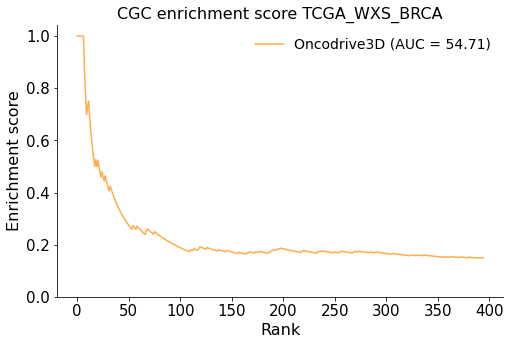

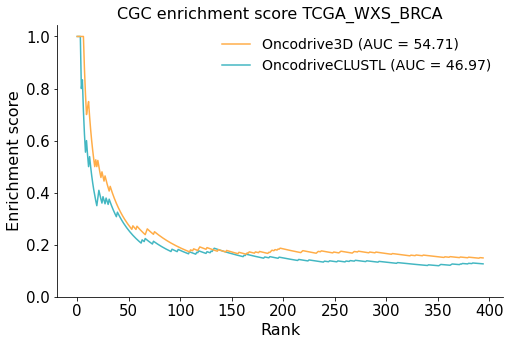

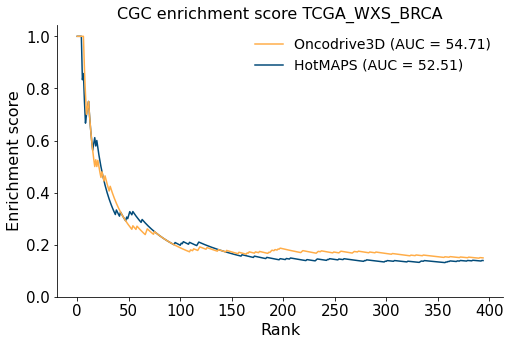

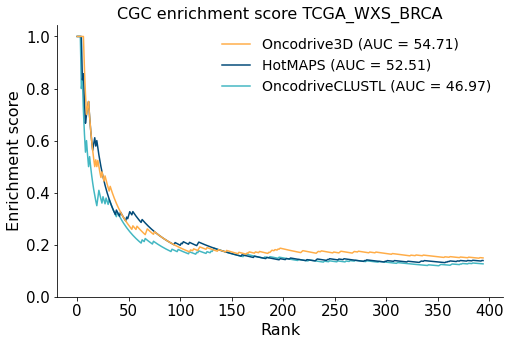

In [7]:
genetable_cohort = genetable[genetable["Cohort"] == cohort]
methods_pval_names = [f"{method}_pval" for method in lst_methods if method != "random"]

col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
min_processed = min_processed_genes(genetable_cohort[col_pvals])

not_na = genetable_cohort[methods_pval_names].notna().all(1)
genetable_cohort = genetable_cohort[not_na]

df_enrich = get_enrich_cohort(genetable_cohort, 
                            lst_methods, 
                            normalize=False, 
                            seed=128, 
                            min_rank_cut_thld=1, 
                            processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)

enrich_target = "CGC"
lst_methods = ["o3d"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
               #   xlim=(0, 614),
                  filename=f'plots/enrichment_cgc_{cohort}_o3d.png')

lst_methods = ["o3d", "clustl"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
               #   xlim=(0, 614),
                  filename=f'plots/enrichment_cgc_{cohort}_o3d_clustl.png')

lst_methods = ["o3d", "hotmaps"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
               #   xlim=(0, 614),
                  filename=f'plots/enrichment_cgc_{cohort}_o3d_hotmaps.png')

lst_methods = ["o3d", "hotmaps", "clustl"] 
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
               #   xlim=(0, 614),
                  filename=f'plots/enrichment_cgc_{cohort}_clustering.png')

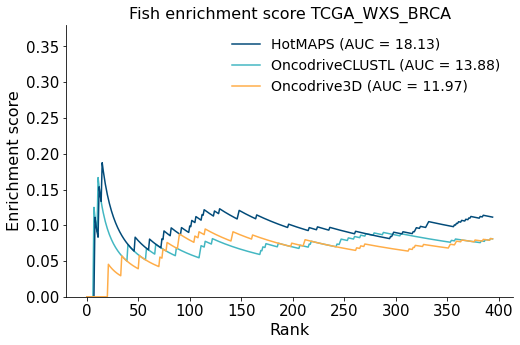

In [8]:
enrich_target = "Fish"
lst_methods = ["o3d", "hotmaps", "clustl"]
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                 # xlim=(0, 614),
                  ylim=(0, 0.38),
                  legend=True,
                  filename=f'plots/enrichment_fishy_{cohort}_clustering.png')

#### All methods

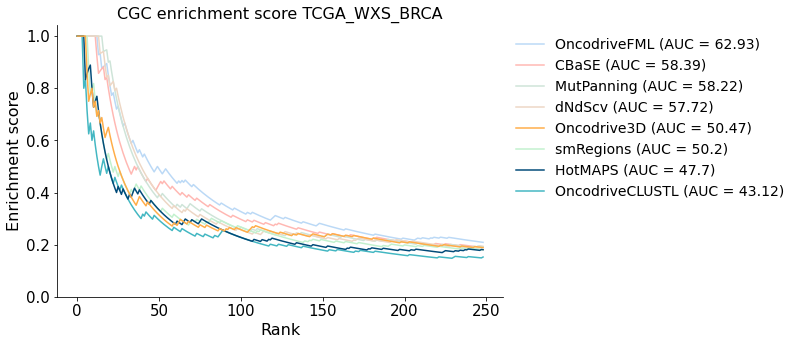

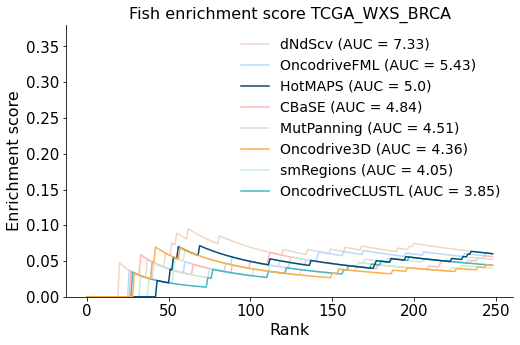

In [9]:
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]
cohort = "TCGA_WXS_BRCA"

genetable_cohort = genetable[genetable["Cohort"] == cohort]
methods_pval_names = [f"{method}_pval" for method in lst_methods if method != "random"]

col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
min_processed = min_processed_genes(genetable_cohort[col_pvals])

not_na = genetable_cohort[methods_pval_names].notna().all(1)
genetable_cohort = genetable_cohort[not_na]

df_enrich = get_enrich_cohort(genetable_cohort, 
                            lst_methods, 
                            normalize=False, 
                            seed=128, 
                            min_rank_cut_thld=1, 
                            processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)

enrich_target = "CGC"
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
               #   xlim=(0, 614),
                  filename=f'plots/enrichment_cgc_{cohort}.png')


enrich_target = "Fish"
enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
plot_enrich_score(df_enrich[enrich_cols], 
                  names_dict, 
                  colors_dict, 
                  title = f"{enrich_target} enrichment score {cohort}", 
                  smooth = False,
                  figsize = (8, 5), 
                  legend_fontsize = 14, 
                  legend_ncol = 1, 
                  legend_outside=True, 
                  style="-",
                 # xlim=(0, 614),
                  ylim=(0, 0.38),
                  legend=True,
                  filename=f'plots/enrichment_fishy_{cohort}.png')

### Enrichment explanatory example

In [10]:
genes_toy = ["PTEN", "KRAS", "TP53", "RBM39", "PIK3CA", "OR10T2", "PPP2R1A", "BCOR", "FBXW7", "SOS1"]
cgc_toy = [1, 1, 1, 0, 1, 0, 1, 1, 1, 0]
fishy_toy = [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
pval_toy= np.zeros(len(genes_toy))
genetable_toy = pd.DataFrame({"Gene" : genes_toy,
                              "CGC" : cgc_toy,
                              "Fish" : fishy_toy,
                              "o3d_pval" : pval_toy,
                              "o3d_rank" : range(len(genes_toy))})
genetable_toy

/tmp/jobs/spellegrini/10373218/ipykernel_393938/2280939435.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  genetable_toy["Gene"][5] = "OR10T2"


,Gene,Uniprot_ID,CGC,Fish,o3d_pval,o3d_rank
0,TP53,K7PPA8,1,0,0.0000,0
1,AKT1,B0LPE5,1,0,0.0000,1
2,SF3B1,O75533,1,0,0.0000,2
3,XKR4,Q5GH76,0,0,0.0046,3
4,ERBB2,P04626,1,0,0.0000,4
5,OR10T2,P54252,0,1,0.0006,5
6,PTEN,F6KD01,1,0,0.0000,6
7,FOXA1,P55317,1,0,0.0000,7
8,ZNF665,Q9H7R5,0,0,0.0000,8
9,RALGAPA2,Q2PPJ7,0,0,0.0059,9


In [11]:
df_enrich = get_enrich_cohort(genetable_toy, 
                              lst_methods=["o3d"], 
                              normalize=False, 
                              seed=128, 
                              min_rank_cut_thld=1, 
                              processed_thld=1)
df_enrich.insert(0, "Cohort", cohort)
df_enrich

,Cohort,o3d_CGC_enrich,o3d_Fish_enrich
0,TCGA_WXS_BRCA,1.000000,0.000000
1,TCGA_WXS_BRCA,1.000000,0.000000
2,TCGA_WXS_BRCA,1.000000,0.000000
3,TCGA_WXS_BRCA,0.750000,0.000000
4,TCGA_WXS_BRCA,0.800000,0.000000
5,TCGA_WXS_BRCA,0.666667,0.166667
6,TCGA_WXS_BRCA,0.714286,0.142857
7,TCGA_WXS_BRCA,0.750000,0.125000
8,TCGA_WXS_BRCA,0.666667,0.111111
9,TCGA_WXS_BRCA,0.600000,0.100000


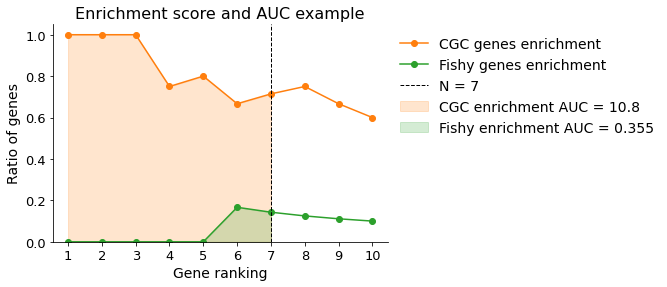

In [12]:
N=7
auc_df=df_enrich#[enrich_cols]
smooth = False
ema_w = 0.9
figsize = (6, 4)
#figsize = (5, 3.5)
legend_fontsize = 14
legend_ncol = 1
legend_frame=False
style="o-"
legend_bbox=(1, 1)
legend_outside=True

#=====
# Plot

auc_df = auc_df.copy()
if "Cohort" in auc_df.columns:
    auc_df = auc_df.drop(columns=["Cohort"])
    
cgc_vec = auc_df[:N]["o3d_CGC_enrich"].values
auc_cgc = auc(cgc_vec)    
fish_vec = auc_df[:N]["o3d_Fish_enrich"].values
auc_fish = auc(fish_vec)    

# Plot
plt.figure(figsize = figsize)

x = auc_df["o3d_CGC_enrich"]
x.index = x.index+1
plt.plot(x, style, color = "#FF7F0E", label = f"CGC genes enrichment")
plt.fill_between(range(1, N+1), x[:N], np.repeat(0, N), color="#FF7F0E", alpha=0.2, label = f"CGC enrichment AUC = {auc_cgc:.3}")

x = auc_df["o3d_Fish_enrich"]
x.index = x.index+1
plt.plot(x, style, color = "#2CA02C", label = f"Fishy genes enrichment")
plt.fill_between(range(1, N+1), x[:N], np.repeat(0, N), color="#2CA02C", alpha=0.2, label = f"Fishy enrichment AUC = {auc_fish:.3}")

plt.axvline(x = N, color = 'black', ls="--", lw=1)#, label = f'N = {N}')

plt.ylabel("Ratio of genes", fontsize = 14)
plt.xlabel("Gene ranking", fontsize = 14)
plt.ylim(0, 1.05)
plt.xticks(range(1, len(auc_df)+1), fontsize=13)
plt.yticks( fontsize=13)
plt.title("Enrichment score and AUC example", fontsize = 16)

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Legend
handles, labels = plt.gca().get_legend_handles_labels()

if legend_outside:
    plt.legend(handles, labels, fontsize=legend_fontsize, ncol=legend_ncol,
               bbox_to_anchor=legend_bbox)
else:
    plt.legend(fontsize = legend_fontsize, ncol = legend_ncol)

if legend_frame == False:
    legend = plt.gca().get_legend()
    legend.set_frame_on(False)
plt.savefig('plots_presentation/enrichment_example.png', dpi=300, bbox_inches='tight')
plt.show()

## AUC

In [8]:
# Load
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
intogen_output = f"{datasets}/output/cancer_202404/intogen_output"
genetable_path = f"/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/data/results/{SUBDIR}/{RUN}.genetable.tsv"

genetable = pd.read_csv(genetable_path, sep="\t", dtype={1 : str, 2 : str, 3 : int})
genetable_noicgc = genetable[[not cohort.startswith("ICGC") for cohort in genetable["Cohort"]]].reset_index(drop=True)
genetable_subset = genetable[genetable["Cohort"].str.startswith("TCGA")]

In [25]:
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)
df_auc

  0%|                                                                                                                | 0/32 [00:00<?, ?it/s]




4


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,POLE,Q07864,Processed,1,0,3.0,0.0213,1.0,345.0,0.012533,...,0.060513,0.201688,1020.0,0.217540,0.895950,NaN,NaN,NaN,ACC,TCGA_WXS_ACC
1,TP53,K7PPA8,Processed,1,0,7.0,0.0427,1.0,0.0,0.000000,...,0.558569,0.558569,0.0,0.000112,0.085960,89.0,0.300615,0.372374,ACC,TCGA_WXS_ACC
2,GLB1L2,A0A024R3N9,Processed,0,0,13.0,0.1200,1.0,333.0,0.012175,...,0.073000,0.201688,3668.0,0.858280,0.987252,NaN,NaN,NaN,ACC,TCGA_WXS_ACC
3,CLTB,P09497,Processed,0,0,19.0,0.2369,1.0,80.0,0.001793,...,0.130500,0.201688,1041.0,0.222710,0.895950,103.0,0.704623,0.735259,ACC,TCGA_WXS_ACC
4,SDS,P20132,Processed,1,0,20.0,0.2594,1.0,219.0,0.007551,...,0.119499,0.201688,1098.0,0.235850,NaN,NaN,NaN,NaN,ACC,TCGA_WXS_ACC



> NONE


None




34


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,IDH2,P48735,Processed,1,0,1.0,0.0000,0.000000,6.0,0.000010,...,0.000014,0.000690,21.0,0.00522,0.599707,46.0,0.092370,0.245945,AML,TCGA_WXS_AML
1,NKTR,P30414,Processed,0,0,2.0,0.0001,0.080525,1247.0,0.063229,...,0.006628,0.032475,4603.0,0.99980,0.999800,NaN,NaN,NaN,AML,TCGA_WXS_AML
2,IDH1,A0A024R3Y6,Processed,1,0,3.0,0.0001,0.080525,40.0,0.000506,...,0.000696,0.011309,85.0,0.01855,0.660124,86.0,0.472966,0.592110,AML,TCGA_WXS_AML
3,ANK2,Q01484,Processed,0,0,6.0,0.0003,0.138043,714.0,0.030960,...,0.047668,0.066735,1708.0,0.36871,0.989098,0.0,0.000017,0.002866,AML,TCGA_WXS_AML
4,BRWD1,Q9NSI6,Processed,0,0,8.0,0.0011,0.386520,70.0,0.001348,...,0.001000,0.011309,4597.0,0.99887,0.999800,NaN,NaN,NaN,AML,TCGA_WXS_AML
5,PTPDC1,A0A087WTF0,Processed,0,0,13.0,0.0023,0.529164,146.0,0.003624,...,0.024806,0.041888,685.0,0.14340,0.895637,NaN,NaN,NaN,AML,TCGA_WXS_AML
6,KRAS,A0A024RAV5,Processed,1,0,15.0,0.0027,0.543544,28.0,0.000248,...,0.106007,0.125164,744.0,0.15448,0.895637,71.0,0.205244,0.317547,AML,TCGA_WXS_AML
7,FLT3,P36888,Processed,1,0,17.0,0.0038,0.679989,7.0,0.000018,...,0.046372,0.065862,159.0,0.03495,0.759335,5.0,0.001144,0.031275,AML,TCGA_WXS_AML
8,ACSL3,A0A024R487,Processed,1,0,19.0,0.0051,0.821355,174.0,0.004606,...,0.002000,0.012251,684.0,0.14337,0.895637,52.0,0.102965,0.248328,AML,TCGA_WXS_AML
9,PTPN11,Q06124,Processed,1,0,24.0,0.0161,1.000000,48.0,0.000925,...,0.225839,0.230544,165.0,0.03637,0.759335,10.0,0.003252,0.046687,AML,TCGA_WXS_AML


o3d cgc: 17.92971137828793 fish: 0.12224530080010657 rank cut: 34
hotmaps cgc: 19.02480569015716 fish: 0.26284120416306905 rank cut: 34
clustl cgc: 20.08507045023638 fish: 0.4072290593996439 rank cut: 34

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_AML,34,17.929711,0.122245,19.024806,0.262841,20.08507,0.407229





815


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,PIK3CA,P42336,Processed,1,0,0.0,0.0,0.0,11.0,0.000000,...,1.238597e-10,1.151069e-07,12.0,0.000002,0.002185,1.0,3.188863e-18,1.800273e-14,BLCA,TCGA_WXS_BLCA
1,FGFR3,P22607,Processed,1,0,1.0,0.0,0.0,2.0,0.000000,...,1.110223e-19,3.095302e-16,14.0,0.000015,0.014203,NaN,NaN,NaN,BLCA,TCGA_WXS_BLCA
2,TP53,K7PPA8,Processed,1,0,2.0,0.0,0.0,8.0,0.000000,...,9.704993e-05,3.307745e-02,11.0,0.000001,0.001184,0.0,1.144836e-39,1.292634e-35,BLCA,TCGA_WXS_BLCA
3,FBXW7,Q969H0,Processed,1,0,3.0,0.0,0.0,16.0,0.000000,...,7.194790e-05,2.865582e-02,0.0,0.000001,0.001184,3.0,7.165085e-09,2.022524e-05,BLCA,TCGA_WXS_BLCA
4,ERBB2,P04626,Processed,1,0,4.0,0.0,0.0,29.0,0.000016,...,7.403800e-14,1.032090e-10,118.0,0.004440,0.553169,2.0,2.975026e-11,1.119701e-07,BLCA,TCGA_WXS_BLCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117,LYST,Q99698,Processed,0,0,2676.0,1.0,1.0,3719.0,0.175140,...,1.329017e-01,4.127231e-01,9431.0,0.551560,0.960443,534.0,3.149883e-02,6.379609e-01,BLCA,TCGA_WXS_BLCA
1118,CSMD3,Q7Z407,Processed,1,0,2677.0,1.0,1.0,443.0,0.008098,...,8.294056e-01,8.317924e-01,10992.0,0.655450,0.979849,84.0,3.165231e-03,4.138550e-01,BLCA,TCGA_WXS_BLCA
1119,PTCH1,Q13635,Processed,1,0,2678.0,1.0,1.0,45.0,0.000083,...,2.753021e-01,4.472008e-01,1186.0,0.059390,0.800264,1781.0,1.406248e-01,7.800958e-01,BLCA,TCGA_WXS_BLCA
1120,KLHDC2,Q9Y2U9,Processed,0,0,2679.0,1.0,1.0,3897.0,0.186908,...,1.713541e-01,4.145781e-01,3170.0,0.170460,0.872194,3769.0,3.621483e-01,8.030840e-01,BLCA,TCGA_WXS_BLCA


o3d cgc: 76.39274837274475 fish: 17.01660054854223 rank cut: 815
hotmaps cgc: 76.8636042004362 fish: 24.297345500884017 rank cut: 815
clustl cgc: 72.33429589346385 fish: 15.03983648834264 rank cut: 815

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_BLCA,815,76.392748,17.016601,76.863604,24.297346,72.334296,15.039836


  9%|█████████▊                                                                                              | 3/32 [00:00<00:01, 22.01it/s]




395


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,PIK3CA,P42336,Processed,1,0,0.0,0.0000,0.0,5.0,0.000000e+00,...,1.110223e-19,8.676393e-17,0.0,0.000001,0.001034,1.0,9.400660e-20,4.161672e-16,BRCA,TCGA_WXS_BRCA
1,TP53,K7PPA8,Processed,1,0,1.0,0.0000,0.0,4.0,0.000000e+00,...,6.271498e-10,3.267450e-07,11.0,0.000001,0.001034,0.0,1.263704e-53,1.118883e-49,BRCA,TCGA_WXS_BRCA
2,AKT1,B0LPE5,Processed,1,0,2.0,0.0000,0.0,13.0,5.357334e-07,...,1.110223e-19,8.676393e-17,15.0,0.000086,0.066671,2.0,4.166868e-18,1.229782e-14,BRCA,TCGA_WXS_BRCA
3,ERBB2,P04626,Processed,1,0,4.0,0.0000,0.0,43.0,2.812600e-04,...,2.658286e-04,5.935572e-02,79.0,0.002030,0.341110,4.0,3.404861e-07,6.029328e-04,BRCA,TCGA_WXS_BRCA
4,PTEN,F6KD01,Processed,1,0,5.0,0.0000,0.0,2.0,0.000000e+00,...,7.405223e-02,3.256383e-01,7.0,0.000001,0.001034,NaN,NaN,NaN,BRCA,TCGA_WXS_BRCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
560,FCN1,O00602,Processed,0,0,1625.0,0.9994,1.0,2676.0,1.214267e-01,...,4.313402e-01,4.688350e-01,3836.0,0.214130,0.873622,1840.0,1.865328e-01,7.190773e-01,BRCA,TCGA_WXS_BRCA
561,PKHD1L1,Q86WI1,Processed,0,0,1626.0,0.9996,1.0,2741.0,1.273824e-01,...,3.951443e-01,4.431790e-01,11748.0,0.744880,0.999836,393.0,3.036634e-02,6.477055e-01,BRCA,TCGA_WXS_BRCA
562,CSMD3,Q7Z407,Processed,1,0,1628.0,0.9999,1.0,2650.0,1.214267e-01,...,7.077022e-01,7.122592e-01,10846.0,0.682170,0.992640,1527.0,1.520507e-01,7.190773e-01,BRCA,TCGA_WXS_BRCA
563,CASP8,Q14790,Processed,1,0,1630.0,1.0000,1.0,0.0,0.000000e+00,...,3.394497e-01,4.200791e-01,13.0,0.000014,0.012404,558.0,4.581251e-02,6.958973e-01,BRCA,TCGA_WXS_BRCA


o3d cgc: 54.714307221392595 fish: 11.96833574009051 rank cut: 395
hotmaps cgc: 52.50839225689125 fish: 18.129244334105216 rank cut: 395
clustl cgc: 46.96898189569719 fish: 13.881206464933477 rank cut: 395

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_BRCA,395,54.714307,11.968336,52.508392,18.129244,46.968982,13.881206





115


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,VHL,A0A024R2F2,Processed,1,0,0.0,0.0000,0.000000,1.0,0.000000,...,0.025355,0.140083,0.0,0.000001,0.001097,2.0,0.000146,0.093721,CCRCC,TCGA_WXS_CCRCC
1,MTOR,P42345,Processed,1,0,1.0,0.0000,0.000000,16.0,0.000043,...,0.009885,0.140083,226.0,0.022040,0.839510,178.0,0.045178,0.430793,CCRCC,TCGA_WXS_CCRCC
2,PIK3CA,P42336,Processed,1,0,3.0,0.0001,0.216525,76.0,0.001152,...,0.199693,0.240503,1639.0,0.140970,0.907140,1078.0,0.713732,0.782344,CCRCC,TCGA_WXS_CCRCC
3,PBRM1,Q86U86,Processed,1,0,4.0,0.0005,0.866100,4.0,0.000000,...,0.210919,0.248033,1.0,0.000001,0.001097,217.0,0.059557,0.430793,CCRCC,TCGA_WXS_CCRCC
4,RAP1GDS1,P52306,Processed,1,0,5.0,0.0040,1.000000,1403.0,0.070740,...,0.276164,0.305242,2198.0,0.192190,0.933875,1.0,0.000038,0.036372,CCRCC,TCGA_WXS_CCRCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,ABCB1,A4D1D2,Processed,0,0,345.0,0.6737,1.000000,25.0,0.000115,...,0.080500,0.140083,255.0,0.024000,0.846085,67.0,0.013634,0.345293,CCRCC,TCGA_WXS_CCRCC
134,TP53,K7PPA8,Processed,1,0,346.0,0.6763,1.000000,82.0,0.001411,...,0.082538,0.141403,14.0,0.001120,0.438800,15.0,0.001436,0.149429,CCRCC,TCGA_WXS_CCRCC
135,OR8G1,A0A126GVX6,Processed,0,1,347.0,0.7127,1.000000,NaN,NaN,...,0.050000,0.140083,2155.0,0.187770,0.931463,782.0,0.310279,0.499433,CCRCC,TCGA_WXS_CCRCC
136,CDK3,Q00526,Processed,0,0,348.0,0.7191,1.000000,1137.0,0.053311,...,0.085500,0.142903,3823.0,0.340470,0.967561,907.0,0.408801,0.559091,CCRCC,TCGA_WXS_CCRCC


o3d cgc: 29.59653430339751 fish: 4.183897050575801 rank cut: 115
hotmaps cgc: 29.95395015149529 fish: 2.9925461024423847 rank cut: 115
clustl cgc: 14.086437067652298 fish: 6.195145415034622 rank cut: 115

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_CCRCC,115,29.596534,4.183897,29.95395,2.992546,14.086437,6.195145





145


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,PIK3CA,P42336,Processed,1,0,0.0,0.0000,0.0,1.0,0.000000,...,1.110223e-18,7.294165e-16,2.0,0.000001,0.001091,0.0,6.488267e-25,2.655648e-21,CESC,TCGA_WXS_CESC
1,MAPK1,P28482,Processed,1,0,1.0,0.0000,0.0,132.0,0.001655,...,4.316098e-06,9.452255e-04,22.0,0.000290,0.115077,NaN,NaN,NaN,CESC,TCGA_WXS_CESC
2,KRAS,A0A024RAV5,Processed,1,0,2.0,0.0000,0.0,50.0,0.000368,...,7.995257e-02,3.325194e-01,753.0,0.049150,0.815230,186.0,2.472070e-02,5.242582e-01,CESC,TCGA_WXS_CESC
3,FBXW7,Q969H0,Processed,1,0,3.0,0.0000,0.0,7.0,0.000000,...,3.066451e-04,5.036646e-02,7.0,0.000001,0.001091,2.0,8.162794e-07,1.113677e-03,CESC,TCGA_WXS_CESC
4,NFE2L2,Q16236,Processed,1,0,4.0,0.0000,0.0,213.0,0.004084,...,3.719556e-01,4.335096e-01,272.0,0.014970,0.643784,NaN,NaN,NaN,CESC,TCGA_WXS_CESC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,CASP8,Q14790,Processed,1,0,622.0,0.9245,1.0,139.0,0.001851,...,1.760663e-01,3.724247e-01,14.0,0.000062,0.038661,1745.0,4.102526e-01,6.428068e-01,CESC,TCGA_WXS_CESC
195,HUWE1,Q7Z6Z7,Processed,0,0,623.0,0.9269,1.0,41.0,0.000264,...,1.989642e-01,3.811976e-01,302.0,0.017220,0.685715,971.0,1.770367e-01,5.697049e-01,CESC,TCGA_WXS_CESC
196,STK11,A0A0S2Z4D1,Processed,1,0,626.0,0.9509,1.0,35.0,0.000209,...,1.129284e-01,3.571067e-01,58.0,0.002090,0.379358,2431.0,9.098658e-01,9.402832e-01,CESC,TCGA_WXS_CESC
197,ACTB,P60709,Processed,0,0,627.0,0.9572,1.0,221.0,0.004380,...,5.000133e-02,3.325194e-01,1182.0,0.080590,0.898132,NaN,NaN,NaN,CESC,TCGA_WXS_CESC


o3d cgc: 33.29815042031992 fish: 8.202268054682063 rank cut: 145
hotmaps cgc: 37.08968785219022 fish: 12.006284676701258 rank cut: 145
clustl cgc: 29.260559310324897 fish: 11.478637789546852 rank cut: 145

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_CESC,145,33.29815,8.202268,37.089688,12.006285,29.260559,11.478638


 19%|███████████████████▌                                                                                    | 6/32 [00:00<00:01, 22.14it/s]




5


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,IDH1,A0A024R3Y6,Processed,1,0,0.0,0.0001,0.0981,5.0,0.000017,...,0.000775,0.010078,14.0,0.00581,0.120073,11.0,0.490646,0.512129,CHOL,TCGA_WXS_CHOL
1,RABGAP1,Q9Y3P9,Processed,0,0,4.0,0.0434,1.0000,79.0,0.002175,...,0.077000,0.125450,944.0,0.63402,NaN,NaN,NaN,NaN,CHOL,TCGA_WXS_CHOL
2,ARAF,A0A024R178,Processed,1,0,6.0,0.0650,1.0000,43.0,0.001040,...,0.044003,0.125450,346.0,0.21021,0.724057,NaN,NaN,NaN,CHOL,TCGA_WXS_CHOL
3,IDH2,P48735,Processed,1,0,7.0,0.1367,1.0000,35.0,0.000812,...,0.110000,0.130000,459.0,0.29477,0.760474,NaN,NaN,NaN,CHOL,TCGA_WXS_CHOL
4,KRAS,A0A024RAV5,Processed,1,0,9.0,0.2546,1.0000,155.0,0.005032,...,0.095500,0.125450,837.0,0.55889,0.850610,NaN,NaN,NaN,CHOL,TCGA_WXS_CHOL


o3d cgc: 7.57827428270033 fish: 0.0 rank cut: 5
hotmaps cgc: 9.537549741844597 fish: 0.0 rank cut: 5
clustl cgc: 8.626225919845021 fish: 0.0 rank cut: 5

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_CHOL,5,7.578274,0.0,9.53755,0.0,8.626226,0.0





2


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,SCAPER,Q9BY12,Processed,0,0,1.0,0.0194,1.0,108.0,0.004111,...,0.133000,0.157634,1016.0,0.638530,NaN,NaN,NaN,NaN,CHRCC,TCGA_WXS_CHRCC
1,TP53,K7PPA8,Processed,1,0,6.0,0.3196,1.0,1.0,0.000000,...,0.533757,0.533757,0.0,0.000001,0.000142,0.0,0.000795,0.007153,CHRCC,TCGA_WXS_CHRCC



> NONE


None




473


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,KRAS,A0A024RAV5,Processed,1,0,0.0,0.0,0.0,7.0,0.000000,...,3.422262e-14,1.479273e-11,10.0,0.000001,0.000914,4.0,5.166977e-13,7.552054e-10,COADREAD,TCGA_WXS_COADREAD
1,TP53,K7PPA8,Processed,1,0,1.0,0.0,0.0,4.0,0.000000,...,9.860637e-07,3.409808e-04,11.0,0.000001,0.000914,0.0,1.380721e-57,1.009031e-53,COADREAD,TCGA_WXS_COADREAD
2,PIK3CA,P42336,Processed,1,0,2.0,0.0,0.0,12.0,0.000000,...,1.110223e-19,9.597878e-17,9.0,0.000001,0.000914,2.0,6.759113e-18,1.646520e-14,COADREAD,TCGA_WXS_COADREAD
3,NRAS,P01111,Processed,1,0,3.0,0.0,0.0,0.0,0.000000,...,1.110223e-19,9.597878e-17,130.0,0.006120,0.587109,55.0,2.956959e-03,3.494161e-01,COADREAD,TCGA_WXS_COADREAD
4,FBXW7,Q969H0,Processed,1,0,5.0,0.0,0.0,14.0,0.000000,...,1.446805e-04,4.169209e-02,3.0,0.000001,0.000914,6.0,1.141202e-08,1.042488e-05,COADREAD,TCGA_WXS_COADREAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
628,OR2M2,A0A126GWI7,Processed,0,1,1596.0,1.0,1.0,NaN,NaN,...,3.575901e-01,4.923145e-01,10081.0,0.680390,0.989470,1589.0,1.761563e-01,6.519093e-01,COADREAD,TCGA_WXS_COADREAD
629,ADAMTS16,Q8TE57,Processed,0,0,1597.0,1.0,1.0,697.0,0.020708,...,3.399090e-01,4.836845e-01,6997.0,0.467930,0.982476,1535.0,1.674940e-01,6.469889e-01,COADREAD,TCGA_WXS_COADREAD
630,PCDH17,O14917,Processed,0,0,1599.0,1.0,1.0,304.0,0.006637,...,4.214373e-01,5.219664e-01,3276.0,0.209530,0.933833,2004.0,2.471193e-01,6.789280e-01,COADREAD,TCGA_WXS_COADREAD
631,TRPC7,Q9HCX4,Processed,0,1,1601.0,1.0,1.0,1472.0,0.059103,...,4.566777e-01,5.397100e-01,5709.0,0.377320,0.971919,NaN,NaN,NaN,COADREAD,TCGA_WXS_COADREAD


o3d cgc: 59.016168935908446 fish: 22.635038850214187 rank cut: 473
hotmaps cgc: 66.14644694225935 fish: 29.514805539265755 rank cut: 473
clustl cgc: 64.07082470741531 fish: 31.271267601434616 rank cut: 473

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_COADREAD,473,59.016169,22.635039,66.146447,29.514806,64.070825,31.271268


 28%|█████████████████████████████▎                                                                          | 9/32 [00:00<00:01, 22.43it/s]




25


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,IGLL5,B9A064,Processed,0,0,2.0,0.0128,1.0,2674.0,0.137678,...,0.593537,0.621359,3757.0,0.96050,0.998319,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
1,SPG11,Q96JI7,Processed,0,0,5.0,0.0142,1.0,449.0,0.019947,...,0.240127,0.344020,2584.0,0.65045,NaN,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
2,CDH4,P55283,Processed,0,0,9.0,0.0371,1.0,573.0,0.026049,...,0.246486,0.344054,1768.0,0.43188,0.900553,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
3,MROH2B,Q7Z745,Processed,0,1,11.0,0.0419,1.0,605.0,0.027849,...,0.057500,0.267819,3103.0,0.79123,0.973094,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
4,KLHL6,Q8WZ60,Processed,0,0,12.0,0.0428,1.0,38.0,0.000274,...,0.220588,0.343707,241.0,0.05294,0.556696,23.0,0.025026,0.172298,DLBCLNOS,TCGA_WXS_DLBCLNOS
5,MYD88,Q99836,Processed,1,0,13.0,0.0450,1.0,21.0,0.000077,...,0.009063,0.267819,9.0,0.00119,0.103649,2.0,0.000951,0.059284,DLBCLNOS,TCGA_WXS_DLBCLNOS
6,STAT3,P40763,Processed,1,0,14.0,0.0528,1.0,33.0,0.000199,...,0.437193,0.489076,772.0,0.16688,0.761099,0.0,0.000049,0.009194,DLBCLNOS,TCGA_WXS_DLBCLNOS
7,XPO1,O14980,Processed,1,0,16.0,0.0594,1.0,525.0,0.023475,...,0.027501,0.267819,581.0,0.12390,0.705339,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
8,FOXC1,Q12948,Processed,0,0,17.0,0.0672,1.0,2.0,0.000004,...,0.315485,0.414461,14.0,0.00216,0.156780,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS
9,CARS2,Q9HA77,Processed,0,0,23.0,0.0792,1.0,292.0,0.011817,...,0.241313,0.344020,513.0,0.10532,NaN,NaN,NaN,NaN,DLBCLNOS,TCGA_WXS_DLBCLNOS


o3d cgc: 5.277537073324574 fish: 3.0297291867081735 rank cut: 25
hotmaps cgc: 10.019198234990832 fish: 2.5836158387798793 rank cut: 25
clustl cgc: 15.941079659937659 fish: 3.778105937403622 rank cut: 25

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_DLBCLNOS,25,5.277537,3.029729,10.019198,2.583616,15.94108,3.778106





113


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0000,0.00000,1.0,0.000000,...,4.571712e-08,0.000017,0.0,0.000001,0.003061,0.0,5.321137e-23,1.475019e-19,ESCA,TCGA_WXS_ESCA
1,NFE2L2,Q16236,Processed,1,0,1.0,0.0000,0.00000,10.0,0.000057,...,1.099569e-01,0.232743,3.0,0.000064,0.097968,NaN,NaN,NaN,ESCA,TCGA_WXS_ESCA
2,PIK3CA,P42336,Processed,1,0,3.0,0.0000,0.00000,15.0,0.000127,...,7.813769e-08,0.000017,376.0,0.032570,0.897035,177.0,3.448593e-02,4.962218e-01,ESCA,TCGA_WXS_ESCA
3,ZFPM2,Q8WW38,Processed,0,0,4.0,0.0002,0.36620,148.0,0.002692,...,7.191575e-01,0.720811,499.0,0.042510,0.897035,NaN,NaN,NaN,ESCA,TCGA_WXS_ESCA
4,SMARCA4,P51532,Processed,1,0,5.0,0.0003,0.45775,142.0,0.002426,...,3.234687e-02,0.170103,709.0,0.061340,0.902170,22.0,2.579765e-03,3.109177e-01,ESCA,TCGA_WXS_ESCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,SPTA1,P02549,Processed,0,0,408.0,0.9151,1.00000,717.0,0.027307,...,4.440349e-01,0.462051,8389.0,0.747510,0.998104,179.0,3.472030e-02,4.962218e-01,ESCA,TCGA_WXS_ESCA
134,EYS,Q5T1H1,Processed,0,0,415.0,0.9793,1.00000,1592.0,0.077359,...,5.562334e-01,0.565309,10664.0,0.951330,1.000000,859.0,2.528052e-01,5.560049e-01,ESCA,TCGA_WXS_ESCA
135,LRP1B,Q9NZR2,Processed,1,0,417.0,0.9930,1.00000,8250.0,0.449823,...,1.266456e-01,0.250087,10771.0,0.961530,1.000000,781.0,2.170478e-01,5.512732e-01,ESCA,TCGA_WXS_ESCA
136,OR4C16,Q8NGL9,Processed,0,1,418.0,0.9996,1.00000,NaN,NaN,...,1.615013e-01,0.262841,2899.0,0.251440,0.948437,NaN,NaN,NaN,ESCA,TCGA_WXS_ESCA


o3d cgc: 25.653994516868693 fish: 4.005881117198632 rank cut: 113
hotmaps cgc: 29.445735709970137 fish: 6.054667344001591 rank cut: 113
clustl cgc: 20.151554638657824 fish: 7.523536875464025 rank cut: 113

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_ESCA,113,25.653995,4.005881,29.445736,6.054667,20.151555,7.523537





221


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,EGFR,P00533,Processed,1,0,0.0,0.0000,0.0,5.0,0.000000,...,1.246939e-09,0.000001,2.0,0.000001,0.001415,1.0,6.066304e-17,1.030665e-13,GBM,TCGA_WXS_GBM
1,IDH1,A0A024R3Y6,Processed,1,0,1.0,0.0000,0.0,6.0,0.000001,...,9.326296e-06,0.004257,374.0,0.029800,0.827212,606.0,1.104462e-01,5.171914e-01,GBM,TCGA_WXS_GBM
2,TP53,K7PPA8,Processed,1,0,2.0,0.0000,0.0,0.0,0.000000,...,3.384101e-02,0.230510,0.0,0.000001,0.001415,0.0,7.049695e-26,2.395486e-22,GBM,TCGA_WXS_GBM
3,BRAF,P15056,Processed,1,0,3.0,0.0000,0.0,1104.0,0.041771,...,6.620768e-03,0.230510,1437.0,0.111100,0.894693,6.0,8.254520e-05,3.506107e-02,GBM,TCGA_WXS_GBM
4,PIK3R1,A0A2X0SFG1,Processed,1,0,4.0,0.0000,0.0,7.0,0.000002,...,2.902334e-03,0.230510,9.0,0.000120,0.084912,5.0,6.832532e-05,3.316706e-02,GBM,TCGA_WXS_GBM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281,SPTA1,P02549,Processed,0,0,712.0,0.9949,1.0,11.0,0.000005,...,3.095648e-02,0.230510,148.0,0.010620,0.754302,1092.0,2.471157e-01,5.650734e-01,GBM,TCGA_WXS_GBM
282,GABRA6,Q16445,Processed,0,1,714.0,0.9972,1.0,76.0,0.000767,...,1.135450e-01,0.262326,6532.0,0.536070,0.980104,1670.0,5.106573e-01,6.842325e-01,GBM,TCGA_WXS_GBM
283,RYR2,Q92736,Processed,0,1,716.0,0.9996,1.0,151.0,0.002248,...,7.466243e-02,0.230510,2051.0,0.157670,0.895214,648.0,1.180843e-01,5.184115e-01,GBM,TCGA_WXS_GBM
284,CD209,Q9NNX6,Processed,1,0,717.0,1.0000,1.0,2307.0,0.111286,...,7.894950e-02,0.230510,9757.0,0.820300,0.999950,1009.0,2.200956e-01,5.523669e-01,GBM,TCGA_WXS_GBM


o3d cgc: 38.22686917486091 fish: 9.190415339956791 rank cut: 221
hotmaps cgc: 43.48716841474356 fish: 9.343230670146466 rank cut: 221
clustl cgc: 36.67230018230481 fish: 9.843151407917192 rank cut: 221

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_GBM,221,38.226869,9.190415,43.487168,9.343231,36.6723,9.843151


 38%|██████████████████████████████████████▋                                                                | 12/32 [00:00<00:00, 21.70it/s]




326


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,CTNNB1,A0A024R2Q3,Processed,1,0,0.0,0.0000,0.0,4.0,0.000000,...,0.000035,0.003348,1.0,0.000001,0.001466,1710.0,3.438506e-01,6.514692e-01,HCC,TCGA_WXS_HCC
1,TP53,K7PPA8,Processed,1,0,1.0,0.0000,0.0,0.0,0.000000,...,0.001327,0.065426,0.0,0.000001,0.001466,0.0,4.134476e-19,1.959328e-15,HCC,TCGA_WXS_HCC
2,NFE2L2,Q16236,Processed,1,0,2.0,0.0000,0.0,25.0,0.000091,...,0.059544,0.129452,6.0,0.000008,0.010054,NaN,NaN,NaN,HCC,TCGA_WXS_HCC
3,EEF1A1,P68104,Processed,0,0,4.0,0.0000,0.0,29.0,0.000142,...,0.000019,0.002359,863.0,0.058340,0.821550,21.0,1.222583e-03,2.508819e-01,HCC,TCGA_WXS_HCC
4,GNAS,A0A0S2Z3H8,Processed,1,0,5.0,0.0008,1.0,1149.0,0.042977,...,0.001421,0.065426,570.0,0.038290,0.798112,1749.0,3.585732e-01,6.552619e-01,HCC,TCGA_WXS_HCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,CSMD3,Q7Z407,Processed,1,0,1013.0,0.9918,1.0,3447.0,0.175673,...,0.332947,0.350243,9948.0,0.730700,0.989872,107.0,1.153402e-02,4.945433e-01,HCC,TCGA_WXS_HCC
428,TPO,P07202,Processed,0,1,1014.0,0.9932,1.0,374.0,0.009214,...,0.014974,0.070681,999.0,0.068460,0.829778,705.0,1.012953e-01,5.854017e-01,HCC,TCGA_WXS_HCC
429,RYR2,Q92736,Processed,0,1,1015.0,0.9970,1.0,2532.0,0.121135,...,0.186575,0.237459,6947.0,0.506160,0.977991,203.0,2.378358e-02,5.353596e-01,HCC,TCGA_WXS_HCC
430,LYZL6,A0A080YUZ6,Processed,0,1,1016.0,1.0000,1.0,1542.0,0.062807,...,0.019001,0.070681,1006.0,0.069060,0.832526,1083.0,1.793903e-01,6.088252e-01,HCC,TCGA_WXS_HCC


o3d cgc: 38.96737661764192 fish: 14.55107320760006 rank cut: 326
hotmaps cgc: 43.84587722325382 fish: 14.555533209590568 rank cut: 326
clustl cgc: 26.286923568298025 fish: 18.312238599408232 rank cut: 326

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_HCC,326,38.967377,14.551073,43.845877,14.555533,26.286924,18.312239





527


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0,0.0,12.0,0.000000,...,1.445631e-03,2.486250e-01,1.0,0.000001,0.001074,0.0,2.225299e-50,2.081990e-46,HNSC,TCGA_WXS_HNSC
1,PIK3CA,P42336,Processed,1,0,1.0,0.0,0.0,2.0,0.000000,...,1.332268e-18,2.649880e-15,11.0,0.000001,0.001074,1.0,3.378168e-15,1.580307e-11,HNSC,TCGA_WXS_HNSC
2,HRAS,P01112,Processed,1,0,2.0,0.0,0.0,13.0,0.000000,...,8.741974e-04,2.173473e-01,103.0,0.003220,0.441414,32.0,1.105721e-03,2.744421e-01,HNSC,TCGA_WXS_HNSC
3,FBXW7,Q969H0,Processed,1,0,3.0,0.0,0.0,27.0,0.000044,...,2.018812e-06,1.338472e-03,12.0,0.000004,0.003965,2.0,4.980197e-09,1.553157e-05,HNSC,TCGA_WXS_HNSC
4,NFE2L2,Q16236,Processed,1,0,4.0,0.0,0.0,150.0,0.001710,...,3.866356e-03,3.495537e-01,19.0,0.000110,0.074603,NaN,NaN,NaN,HNSC,TCGA_WXS_HNSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,SIRPB1,O00241,Processed,0,0,1922.0,1.0,1.0,737.0,0.021624,...,9.949987e-02,3.565667e-01,11762.0,0.741770,0.996664,NaN,NaN,NaN,HNSC,TCGA_WXS_HNSC
716,SFRP4,Q6FHJ7,Processed,1,0,1923.0,1.0,1.0,3304.0,0.160529,...,5.191968e-01,5.567021e-01,6238.0,0.383300,0.969663,4138.0,5.362642e-01,8.099816e-01,HNSC,TCGA_WXS_HNSC
717,OR4M2,Q8NGB6,Processed,0,1,1924.0,1.0,1.0,NaN,NaN,...,4.127137e-01,4.787756e-01,7873.0,0.489490,0.978601,5342.0,9.607704e-01,9.822596e-01,HNSC,TCGA_WXS_HNSC
718,CTNNA2,P26232,Processed,1,0,1925.0,1.0,1.0,3176.0,0.152810,...,2.545117e-01,4.165014e-01,9904.0,0.622360,0.991629,3594.0,4.178951e-01,7.665081e-01,HNSC,TCGA_WXS_HNSC


o3d cgc: 61.9515010836984 fish: 17.516113502616967 rank cut: 527
hotmaps cgc: 59.39335787588115 fish: 30.42219709783894 rank cut: 527
clustl cgc: 58.81361213797178 fish: 21.022326040930018 rank cut: 527

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_HNSC,527,61.951501,17.516114,59.393358,30.422197,58.813612,21.022326





62


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,IDH1,A0A024R3Y6,Processed,1,0,0.0,0.0000,0.0,1.0,0.000000,...,3.330669e-19,7.827072e-17,0.0,0.000001,0.000543,2.0,4.194918e-10,2.143603e-07,LGGNOS,TCGA_WXS_LGGNOS
1,TP53,K7PPA8,Processed,1,0,1.0,0.0000,0.0,8.0,0.000000,...,4.906262e-08,5.764858e-06,1.0,0.000001,0.000543,0.0,1.328400e-63,2.036437e-60,LGGNOS,TCGA_WXS_LGGNOS
2,CIC,Q96RK0,Processed,1,0,2.0,0.0000,0.0,10.0,0.000000,...,1.730052e-03,6.776036e-02,3.0,0.000001,0.000543,1.0,3.774867e-61,2.893436e-58,LGGNOS,TCGA_WXS_LGGNOS
3,IDH2,P48735,Processed,1,0,3.0,0.0000,0.0,3.0,0.000000,...,1.623265e-06,1.271557e-04,10.0,0.000110,0.043440,36.0,6.521640e-03,2.477611e-01,LGGNOS,TCGA_WXS_LGGNOS
4,EGFR,P00533,Processed,1,0,4.0,0.0000,0.0,4.0,0.000000,...,6.005751e-04,2.822703e-02,6.0,0.000001,0.000543,3.0,2.714094e-07,1.040177e-04,LGGNOS,TCGA_WXS_LGGNOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,COL6A3,P12111,Processed,0,0,204.0,0.7269,1.0,380.0,0.010956,...,8.125294e-02,2.486270e-01,1565.0,0.150160,0.857954,155.0,5.151899e-02,4.494362e-01,LGGNOS,TCGA_WXS_LGGNOS
69,OR5H14,A6NHG9,Processed,0,1,205.0,0.7363,1.0,NaN,NaN,...,2.389577e-01,3.521429e-01,5524.0,0.579410,0.976322,560.0,2.986288e-01,5.124066e-01,LGGNOS,TCGA_WXS_LGGNOS
70,OR2T2,Q6IF00,Processed,0,1,210.0,0.8403,1.0,NaN,NaN,...,2.849855e-01,3.762007e-01,3877.0,0.391760,0.924831,448.0,2.026967e-01,4.614290e-01,LGGNOS,TCGA_WXS_LGGNOS
71,RYR2,Q92736,Processed,0,1,212.0,0.9045,1.0,17.0,0.000028,...,3.110196e-01,3.824174e-01,2643.0,0.260810,0.897974,279.0,1.144483e-01,4.528547e-01,LGGNOS,TCGA_WXS_LGGNOS


o3d cgc: 30.130671796007544 fish: 2.641602674771826 rank cut: 62
hotmaps cgc: 32.30160294113755 fish: 2.34285423359808 rank cut: 62
clustl cgc: 30.81513741292985 fish: 2.0699520475898576 rank cut: 62

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_LGGNOS,62,30.130672,2.641603,32.301603,2.342854,30.815137,2.069952


 47%|████████████████████████████████████████████████▎                                                      | 15/32 [00:00<00:00, 21.45it/s]




1696


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,KRAS,A0A024RAV5,Processed,1,0,0.0,0.0,0.0,9.0,0.000000,...,1.110223e-19,2.650102e-16,9.0,0.000001,0.001336,3.0,1.535205e-11,4.264013e-08,LUAD,TCGA_WXS_LUAD
1,TP53,K7PPA8,Processed,1,0,1.0,0.0,0.0,10.0,0.000000,...,7.594535e-02,4.063895e-01,3.0,0.000001,0.001336,0.0,1.835010e-30,2.392486e-26,LUAD,TCGA_WXS_LUAD
2,EGFR,P00533,Processed,1,0,2.0,0.0,0.0,7.0,0.000000,...,1.110223e-19,2.650102e-16,4.0,0.000001,0.001336,1.0,2.179258e-18,1.420658e-14,LUAD,TCGA_WXS_LUAD
3,BRAF,P15056,Processed,1,0,4.0,0.0,0.0,5.0,0.000000,...,4.518172e-08,4.313950e-05,14.0,0.000031,0.030368,5.0,1.186257e-10,2.577737e-07,LUAD,TCGA_WXS_LUAD
4,CTNNB1,A0A024R2Q3,Processed,1,0,5.0,0.0,0.0,163.0,0.002105,...,1.245577e-02,4.063895e-01,174.0,0.006460,0.578800,7297.0,9.144442e-01,9.710316e-01,LUAD,TCGA_WXS_LUAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2192,ITGA4,P13612,Processed,0,0,4594.0,1.0,1.0,2314.0,0.096295,...,1.561556e-01,4.354479e-01,10107.0,0.592010,0.978199,4780.0,4.152685e-01,8.117053e-01,LUAD,TCGA_WXS_LUAD
2193,IFNA16,A0A7R8C397,Processed,0,1,4595.0,1.0,1.0,5175.0,0.276700,...,5.578381e-01,6.147499e-01,2424.0,0.131970,0.897669,NaN,NaN,NaN,LUAD,TCGA_WXS_LUAD
2194,OR4A47,Q6IF82,Processed,0,1,4596.0,1.0,1.0,NaN,NaN,...,2.485884e-01,4.510269e-01,5970.0,0.341180,0.954370,5583.0,5.342417e-01,8.502739e-01,LUAD,TCGA_WXS_LUAD
2195,TMPRSS11E,Q9UL52,Processed,0,0,4598.0,1.0,1.0,920.0,0.028608,...,3.390469e-01,4.808704e-01,10665.0,0.625830,0.979751,4494.0,3.727724e-01,7.946860e-01,LUAD,TCGA_WXS_LUAD


o3d cgc: 93.55975941683354 fish: 73.3471559118771 rank cut: 1696
hotmaps cgc: 85.90318172542639 fish: 118.87734599279246 rank cut: 1696
clustl cgc: 86.6644403224067 fish: 70.83685686052567 rank cut: 1696

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_LUAD,1696,93.559759,73.347156,85.903182,118.877346,86.66444,70.836857





1426


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,NFE2L2,Q16236,Processed,1,0,0.0,0.0,0.0,6.0,0.000000,...,0.002892,0.380525,3.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
1,TP53,K7PPA8,Processed,1,0,1.0,0.0,0.0,11.0,0.000000,...,0.000055,0.073971,1.0,0.000001,0.001441,0.0,9.534979e-56,1.202361e-51,LUSC,TCGA_WXS_LUSC
2,PIK3CA,P42336,Processed,1,0,2.0,0.0,0.0,53.0,0.000388,...,0.000004,0.007465,29.0,0.000310,0.148955,1.0,8.013395e-12,5.052445e-08,LUSC,TCGA_WXS_LUSC
3,CDKN2A,K7PML8,Processed,1,0,3.0,0.0,0.0,5.0,0.000000,...,0.000399,0.266155,5.0,0.000001,0.001441,NaN,NaN,NaN,LUSC,TCGA_WXS_LUSC
4,HRAS,P01112,Processed,1,0,4.0,0.0,0.0,990.0,0.033670,...,0.003380,0.380525,2313.0,0.129510,0.927878,2046.0,1.413890e-01,7.547557e-01,LUSC,TCGA_WXS_LUSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,OR4C13,Q8NGP0,Processed,0,1,3968.0,1.0,1.0,NaN,NaN,...,0.335128,0.468247,8908.0,0.530160,0.987234,4489.0,4.044634e-01,8.102119e-01,LUSC,TCGA_WXS_LUSC
1874,ACTC1,P68032,Processed,0,0,3970.0,1.0,1.0,493.0,0.012646,...,0.442724,0.530025,540.0,0.027450,0.821924,5123.0,5.006042e-01,8.363544e-01,LUSC,TCGA_WXS_LUSC
1875,OR5W2,Q8NH69,Processed,0,1,3972.0,1.0,1.0,NaN,NaN,...,0.794977,0.799166,3549.0,0.200910,0.937045,936.0,5.153635e-02,6.447157e-01,LUSC,TCGA_WXS_LUSC
1876,OR5D16,Q8NGK9,Processed,0,1,3973.0,1.0,1.0,NaN,NaN,...,0.391707,0.496958,4388.0,0.253190,0.952602,2540.0,1.848846e-01,7.604170e-01,LUSC,TCGA_WXS_LUSC


o3d cgc: 76.41430064516229 fish: 56.87300916971346 rank cut: 1426
hotmaps cgc: 74.15691539166298 fish: 117.41138853552982 rank cut: 1426
clustl cgc: 78.69723008026729 fish: 64.72982226848015 rank cut: 1426

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_LUSC,1426,76.414301,56.873009,74.156915,117.411389,78.69723,64.729822





4947


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,BRAF,P15056,Processed,1,0,0.0,0.0,0.0,1.0,0.000000,...,1.110223e-19,3.279599e-16,0.0,0.000001,0.002834,0.0,4.357391e-121,7.621077e-117,MEL,TCGA_WXS_MEL
1,NRAS,P01111,Processed,1,0,1.0,0.0,0.0,0.0,0.000000,...,1.110223e-19,3.279599e-16,1.0,0.000001,0.002834,3.0,8.484731e-12,3.709949e-08,MEL,TCGA_WXS_MEL
2,MAP2K1,A4QPA9,Processed,1,0,2.0,0.0,0.0,28.0,0.000091,...,1.971039e-05,1.293877e-02,663.0,0.026530,0.710419,4771.0,2.574161e-01,7.467505e-01,MEL,TCGA_WXS_MEL
3,RAC1,A4D2P1,Processed,1,0,4.0,0.0,0.0,196.0,0.002776,...,1.017112e-07,1.001517e-04,3221.0,0.167820,0.923751,1228.0,3.349185e-02,4.446233e-01,MEL,TCGA_WXS_MEL
4,IDH1,A0A024R3Y6,Processed,1,0,5.0,0.0,0.0,1060.0,0.033520,...,2.468522e-11,4.166866e-08,333.0,0.011640,0.612776,3089.0,1.316976e-01,6.405626e-01,MEL,TCGA_WXS_MEL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6114,OR13A1,A0A126GVD8,Processed,0,1,10052.0,1.0,1.0,NaN,NaN,...,7.501335e-01,7.665987e-01,4425.0,0.237010,0.951325,9209.0,7.870196e-01,9.339199e-01,MEL,TCGA_WXS_MEL
6115,OR4X1,Q8NH49,Processed,0,1,10053.0,1.0,1.0,NaN,NaN,...,5.029944e-01,5.908928e-01,12415.0,0.725920,0.999990,NaN,NaN,NaN,MEL,TCGA_WXS_MEL
6116,PGAM2,P15259,Processed,0,0,10054.0,1.0,1.0,508.0,0.011072,...,7.178980e-01,7.401346e-01,1326.0,0.060750,0.813716,6725.0,4.424392e-01,8.249525e-01,MEL,TCGA_WXS_MEL
6117,ENPP4,Q9Y6X5,Processed,0,0,10055.0,1.0,1.0,2642.0,0.119139,...,1.634170e-01,4.243438e-01,12854.0,0.750620,0.999990,2493.0,9.487969e-02,5.850246e-01,MEL,TCGA_WXS_MEL


o3d cgc: 157.66302879102508 fish: 165.89643260622967 rank cut: 4947
hotmaps cgc: 155.55421381514026 fish: 238.0310166063924 rank cut: 4947
clustl cgc: 139.0761451384502 fish: 218.78236974559636 rank cut: 4947

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_MEL,4947,157.663029,165.896433,155.554214,238.031017,139.076145,218.78237


 56%|█████████████████████████████████████████████████████████▉                                             | 18/32 [00:00<00:00, 18.85it/s]




6


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,KIT,P10721,Processed,1,0,0.0,0.0000,0.000000,1.0,0.000000,...,0.000222,0.002774,0.0,0.000001,0.000273,0.0,0.000001,0.000033,MGCT,TCGA_WXS_MGCT
1,KRAS,A0A024RAV5,Processed,1,0,1.0,0.0000,0.000000,2.0,0.000000,...,0.001282,0.009375,31.0,0.011900,0.490230,10.0,0.068566,0.098097,MGCT,TCGA_WXS_MGCT
2,NRAS,P01111,Processed,1,0,2.0,0.0008,0.410667,4.0,0.000061,...,0.014291,0.056251,738.0,0.311400,0.860308,14.0,0.203681,0.222197,MGCT,TCGA_WXS_MGCT
3,ANKRD11,Q6UB99,Processed,0,0,4.0,0.0182,1.000000,117.0,0.003945,...,0.092500,0.119375,677.0,0.286990,0.858064,NaN,NaN,NaN,MGCT,TCGA_WXS_MGCT
4,NISCH,Q9Y2I1,Processed,0,0,12.0,0.0681,1.000000,21.0,0.000355,...,0.273649,0.273649,602.0,0.249360,0.820184,2.0,0.003171,0.025367,MGCT,TCGA_WXS_MGCT
5,ASB9,A0A024RBW7,Processed,0,0,14.0,0.1776,1.000000,160.0,0.006053,...,0.077500,0.119375,680.0,0.289130,NaN,NaN,NaN,NaN,MGCT,TCGA_WXS_MGCT
6,PIK3CA,P42336,Processed,1,0,15.0,0.1793,1.000000,43.0,0.000979,...,0.016500,0.056251,157.0,0.069760,0.680160,7.0,0.051701,0.096672,MGCT,TCGA_WXS_MGCT


o3d cgc: 9.514508491766025 fish: 0.0 rank cut: 6
hotmaps cgc: 10.32641285014789 fish: 0.0 rank cut: 6
clustl cgc: 10.32641285014789 fish: 0.0 rank cut: 6

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_MGCT,6,9.514508,0.0,10.326413,0.0,10.326413,0.0





205


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0000,0.000000,0.0,0.000000,...,0.000006,0.001378,0.0,0.000001,0.004266,0.0,2.326973e-57,1.095073e-53,OVT,TCGA_WXS_OVT
1,TOP2A,P11388,Processed,0,0,1.0,0.0000,0.000000,2652.0,0.136828,...,0.000002,0.000745,3283.0,0.236010,0.931074,1.0,2.725979e-06,6.414228e-03,OVT,TCGA_WXS_OVT
2,BICD2,Q8TD16,Processed,0,0,2.0,0.0001,0.373333,1857.0,0.091716,...,0.024377,0.181396,5147.0,0.374650,NaN,1446.0,2.940174e-01,6.629389e-01,OVT,TCGA_WXS_OVT
3,KRAS,A0A024RAV5,Processed,1,0,3.0,0.0002,0.560000,765.0,0.029695,...,0.000980,0.129575,1170.0,0.081950,0.881322,1040.0,1.894581e-01,6.510084e-01,OVT,TCGA_WXS_OVT
4,OAS2,P29728,Processed,0,0,8.0,0.0036,1.000000,2667.0,0.138399,...,0.253547,0.317348,2091.0,0.146910,0.905608,171.0,1.770519e-02,4.592289e-01,OVT,TCGA_WXS_OVT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
283,NLRP3,A0A7I2R3P8,Processed,0,0,786.0,0.9274,1.000000,969.0,0.040474,...,0.120475,0.212769,10454.0,0.794840,0.999910,818.0,1.377134e-01,6.255559e-01,OVT,TCGA_WXS_OVT
284,ALDH1L1,O75891,Processed,0,0,788.0,0.9334,1.000000,761.0,0.029695,...,0.375163,0.396613,9038.0,0.680500,0.992488,519.0,8.157478e-02,6.121312e-01,OVT,TCGA_WXS_OVT
285,RYR2,Q92736,Processed,0,1,796.0,0.9795,1.000000,240.0,0.007577,...,0.033627,0.181396,3911.0,0.280530,0.943010,248.0,3.386753e-02,5.795968e-01,OVT,TCGA_WXS_OVT
286,CA6,P23280,Processed,0,1,797.0,0.9886,1.000000,1181.0,0.051494,...,0.402819,0.420938,1199.0,0.084300,0.885209,NaN,NaN,NaN,OVT,TCGA_WXS_OVT


o3d cgc: 20.276825179188023 fish: 9.649980639922198 rank cut: 205
hotmaps cgc: 26.576770361110746 fish: 8.64640493146024 rank cut: 205
clustl cgc: 15.151129183866727 fish: 11.398834455524455 rank cut: 205

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_OVT,205,20.276825,9.649981,26.57677,8.646405,15.151129,11.398834





20


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,KRAS,A0A024RAV5,Processed,1,0,0.0,0.0000,0.0,1.0,0.000000,...,7.717160e-16,7.717160e-14,0.0,0.000001,0.000365,1.0,5.680531e-08,1.130426e-05,PAAD,TCGA_WXS_PAAD
1,TP53,K7PPA8,Processed,1,0,1.0,0.0000,0.0,0.0,0.000000,...,2.038834e-01,3.102736e-01,1.0,0.000001,0.000365,0.0,2.894945e-18,1.152188e-15,PAAD,TCGA_WXS_PAAD
2,GNAS,A0A0S2Z3H8,Processed,1,0,2.0,0.0000,0.0,25.0,0.000125,...,1.078804e-02,2.806973e-01,45.0,0.007880,0.509029,129.0,1.964132e-01,3.521281e-01,PAAD,TCGA_WXS_PAAD
3,SMAD4,A0A024R274,Processed,1,0,3.0,0.0000,0.0,2.0,0.000000,...,7.578828e-02,2.806973e-01,3.0,0.000001,0.000365,23.0,2.479720e-02,2.582445e-01,PAAD,TCGA_WXS_PAAD
4,NOBOX,O60393,Processed,0,1,7.0,0.0217,1.0,626.0,0.025714,...,5.800648e-02,2.806973e-01,167.0,0.029010,0.661337,NaN,NaN,NaN,PAAD,TCGA_WXS_PAAD
5,SLC12A3,P55017,Processed,0,0,13.0,0.0453,1.0,919.0,0.041512,...,1.814669e-01,3.102736e-01,3164.0,0.600200,0.971419,NaN,NaN,NaN,PAAD,TCGA_WXS_PAAD
6,CACNA1H,O95180,Processed,0,0,26.0,0.0784,1.0,262.0,0.007241,...,1.479972e-01,3.102736e-01,1459.0,0.260710,0.898774,25.0,2.753097e-02,2.582445e-01,PAAD,TCGA_WXS_PAAD
7,SLC11A1,P49279,Processed,0,0,29.0,0.1016,1.0,420.0,0.014903,...,3.047384e-01,3.770900e-01,556.0,0.098730,NaN,NaN,NaN,NaN,PAAD,TCGA_WXS_PAAD
8,OBSCN,Q5VST9,Processed,0,1,33.0,0.1290,1.0,63.0,0.000947,...,2.817634e-01,3.626098e-01,1548.0,0.276590,0.898774,38.0,3.798107e-02,2.582445e-01,PAAD,TCGA_WXS_PAAD
9,CAPZA1,P52907,Processed,0,0,38.0,0.1434,1.0,777.0,0.034057,...,1.349979e-01,3.102736e-01,2024.0,0.367380,NaN,NaN,NaN,NaN,PAAD,TCGA_WXS_PAAD


o3d cgc: 14.55821395045552 fish: 2.5556899331933725 rank cut: 20
hotmaps cgc: 15.813380002608255 fish: 0.451553236886408 rank cut: 20
clustl cgc: 13.731863756249698 fish: 2.6313184195883363 rank cut: 20

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_PAAD,20,14.558214,2.55569,15.81338,0.451553,13.731864,2.631318


 66%|███████████████████████████████████████████████████████████████████▌                                   | 21/32 [00:01<00:00, 20.55it/s]




6


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,HRAS,P01112,Processed,1,0,0.0,0.0000,0.000,0.0,0.000000e+00,...,3.918919e-12,7.837837e-11,61.0,0.03661,0.601014,2.0,0.023442,0.050790,PGNG,TCGA_WXS_PGNG
1,RET,A0A024R7T2,Processed,1,0,2.0,0.0015,0.695,3.0,5.357334e-07,...,6.049052e-03,4.116967e-02,16.0,0.01032,0.584351,4.0,0.058877,0.095675,PGNG,TCGA_WXS_PGNG
2,FGFR1,P11362,Processed,1,0,6.0,0.0504,1.000,70.0,3.010822e-03,...,2.050051e-02,1.025025e-01,633.0,0.30919,0.862779,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
3,PMM1,A0A024R1U5,Processed,0,0,8.0,0.1913,1.000,38.0,1.588985e-03,...,8.000003e-02,1.374995e-01,331.0,0.16154,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
4,NAGK,A0A384N6G7,Processed,0,0,9.0,0.2144,1.000,42.0,1.779171e-03,...,8.850016e-02,1.374995e-01,353.0,0.17085,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG
5,ADH6,P28332,Processed,0,1,10.0,0.2183,1.000,115.0,5.221258e-03,...,7.150024e-02,1.374995e-01,392.0,0.18687,NaN,NaN,NaN,NaN,PGNG,TCGA_WXS_PGNG


o3d cgc: 9.514508491766025 fish: 0.19721577707582308 rank cut: 6
hotmaps cgc: 9.514508491766025 fish: 0.8119043583818651 rank cut: 6
clustl cgc: 9.514508491766025 fish: 0.8119043583818651 rank cut: 6

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_PGNG,6,9.514508,0.197216,9.514508,0.811904,9.514508,0.811904





8


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,KIAA0586,Q9BVV6,Processed,0,0,0.0,0.0086,1.0,240.0,0.012802,...,0.108000,0.168055,695.0,0.254190,NaN,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
1,SMURF1,Q9HCE7,Processed,0,0,5.0,0.0441,1.0,261.0,0.014637,...,0.062000,0.168055,1153.0,0.429670,0.994145,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
2,TP53,K7PPA8,Processed,1,0,7.0,0.0835,1.0,0.0,0.000000,...,0.292803,0.305004,1.0,0.000003,0.000522,0.0,0.00158,0.069514,PLMESO,TCGA_WXS_PLMESO
3,PTEN,F6KD01,Processed,1,0,8.0,0.1343,1.0,238.0,0.012802,...,0.133499,0.175656,1387.0,0.519150,0.994145,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
4,SLC10A5,Q5PT55,Processed,0,0,9.0,0.1409,1.0,187.0,0.008703,...,0.120499,0.168055,115.0,0.044090,NaN,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
5,OR2T2,Q6IF00,Processed,0,1,10.0,0.1596,1.0,NaN,NaN,...,0.064000,0.168055,460.0,0.160280,NaN,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
6,WDR89,A0A024R667,Processed,0,0,11.0,0.1727,1.0,248.0,0.014053,...,0.014500,0.168055,502.0,0.175980,0.798814,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO
7,FANK1,Q8TC84,Processed,0,0,13.0,0.1825,1.0,173.0,0.008211,...,0.153997,0.183330,1253.0,0.461750,NaN,NaN,NaN,NaN,PLMESO,TCGA_WXS_PLMESO


o3d cgc: 2.755825412806118 fish: 0.4863967838564031 rank cut: 8
hotmaps cgc: 7.1257051448381725 fish: 0.7434162256440968 rank cut: 8
clustl cgc: 0.6173907384994897 fish: 1.6547400476436724 rank cut: 8

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_PLMESO,8,2.755825,0.486397,7.125705,0.743416,0.617391,1.65474





58


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,SPOP,O43791,Processed,1,0,0.0,0.0000,0.00000,0.0,0.000000,...,2.343975e-07,0.000060,0.0,0.000001,0.001453,0.0,1.353662e-31,1.972286e-28,PRAD,TCGA_WXS_PRAD
1,TP53,K7PPA8,Processed,1,0,1.0,0.0000,0.00000,1.0,0.000000,...,1.707673e-01,0.296640,1.0,0.000001,0.001453,1.0,9.487337e-10,6.911525e-07,PRAD,TCGA_WXS_PRAD
2,CTNNB1,A0A024R2Q3,Processed,1,0,3.0,0.0000,0.00000,41.0,0.000576,...,1.463592e-01,0.296640,400.0,0.040470,0.823022,NaN,NaN,NaN,PRAD,TCGA_WXS_PRAD
3,FOXA1,P55317,Processed,1,0,4.0,0.0001,0.15032,4.0,0.000005,...,2.385932e-01,0.341472,2.0,0.000001,0.001453,9.0,2.419664e-04,3.484593e-02,PRAD,TCGA_WXS_PRAD
4,BRAF,P15056,Processed,1,0,5.0,0.0011,1.00000,119.0,0.002541,...,8.857995e-02,0.296640,512.0,0.050730,0.824261,166.0,5.449731e-02,4.184940e-01,PRAD,TCGA_WXS_PRAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69,RYR2,Q92736,Processed,0,1,219.0,0.7983,1.00000,5899.0,0.305441,...,4.911247e-01,0.502959,7773.0,0.823620,0.998558,333.0,1.310363e-01,4.184940e-01,PRAD,TCGA_WXS_PRAD
70,ATM,Q13315,Processed,1,0,220.0,0.8803,1.00000,145.0,0.003259,...,3.763991e-02,0.260626,108.0,0.010480,0.681669,37.0,5.023594e-03,1.829844e-01,PRAD,TCGA_WXS_PRAD
71,GRIA1,P42261,Processed,0,0,221.0,0.8969,1.00000,1622.0,0.079253,...,4.970770e-02,0.260626,5303.0,0.545720,0.985554,707.0,5.115136e-01,6.443121e-01,PRAD,TCGA_WXS_PRAD
72,LRP1B,Q9NZR2,Processed,1,0,222.0,0.9240,1.00000,2184.0,0.107505,...,4.049409e-02,0.260626,4668.0,0.473260,0.972256,60.0,1.123318e-02,2.570790e-01,PRAD,TCGA_WXS_PRAD


o3d cgc: 26.183604937756005 fish: 3.2233794547463788 rank cut: 58
hotmaps cgc: 27.512630442097585 fish: 7.8935119561926115 rank cut: 58
clustl cgc: 26.23371663048239 fish: 5.409849209484693 rank cut: 58

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_PRAD,58,26.183605,3.223379,27.51263,7.893512,26.233717,5.409849





86


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,MET,P08581,Processed,1,0,0.0,0.0002,1.0,0.0,5.357334e-07,...,0.000827,0.101502,0.0,0.000103,0.559084,0.0,7.871268e-09,0.000014,PRCC,TCGA_WXS_PRCC
1,NFE2L2,Q16236,Processed,1,0,2.0,0.0004,1.0,140.0,3.224579e-03,...,0.247978,0.279664,1196.0,0.103130,0.859795,NaN,NaN,NaN,PRCC,TCGA_WXS_PRCC
2,SLC5A12,Q1EHB4,Processed,0,0,3.0,0.0005,1.0,844.0,3.586146e-02,...,0.127232,0.179986,4831.0,0.428650,0.937932,61.0,1.422955e-02,0.374330,PRCC,TCGA_WXS_PRCC
3,KRAS,A0A024RAV5,Processed,1,0,4.0,0.0020,1.0,430.0,1.379781e-02,...,0.000009,0.002342,2465.0,0.216010,0.905852,606.0,2.299754e-01,0.458140,PRCC,TCGA_WXS_PRCC
4,FRYL,O94915,Processed,0,0,5.0,0.0022,1.0,2591.0,1.253605e-01,...,0.008016,0.141686,7165.0,0.647690,0.967656,232.0,7.096901e-02,0.427241,PRCC,TCGA_WXS_PRCC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102,FGFR3,P22607,Processed,1,0,289.0,0.6810,1.0,497.0,1.670685e-02,...,0.162032,0.206871,2260.0,0.196800,0.901735,573.0,2.130600e-01,0.450233,PRCC,TCGA_WXS_PRCC
103,PEBP1,D9IAI1,Processed,0,0,291.0,0.7424,1.0,793.0,3.316940e-02,...,0.090000,0.142649,1313.0,0.113190,0.868262,302.0,9.534429e-02,0.427241,PRCC,TCGA_WXS_PRCC
104,CNDP2,Q96KP4,Processed,0,0,292.0,0.7553,1.0,209.0,5.920390e-03,...,0.207012,0.246472,1377.0,0.118380,0.868262,385.0,1.257200e-01,0.427241,PRCC,TCGA_WXS_PRCC
105,ALDH2,A0A384NPN7,Processed,1,0,294.0,0.8108,1.0,202.0,5.530912e-03,...,0.079500,0.141686,586.0,0.052380,0.859795,660.0,2.655150e-01,0.477401,PRCC,TCGA_WXS_PRCC


o3d cgc: 21.238663386314617 fish: 2.4189514500426434 rank cut: 86
hotmaps cgc: 23.545040639663796 fish: 4.323411584749227 rank cut: 86
clustl cgc: 20.746666978672142 fish: 3.4767317123137564 rank cut: 86

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_PRCC,86,21.238663,2.418951,23.545041,4.323412,20.746667,3.476732


 78%|████████████████████████████████████████████████████████████████████████████████▍                      | 25/32 [00:01<00:00, 23.50it/s]




35


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0000,0.0,0.0,0.000000,...,0.046861,0.159415,0.0,0.000001,0.001122,0.0,3.952689e-11,4.454681e-08,SOFT_TISSUE,TCGA_WXS_SARC
1,GLCCI1,Q86VQ1,Processed,0,0,3.0,0.0213,1.0,1389.0,0.077618,...,0.056500,0.159415,1645.0,0.194730,NaN,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
2,COL28A1,Q2UY09,Processed,0,0,5.0,0.0230,1.0,1762.0,0.097364,...,0.239189,0.268524,2951.0,0.341330,0.959102,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
3,LYST,Q99698,Processed,0,0,9.0,0.0268,1.0,658.0,0.033822,...,0.011018,0.159415,514.0,0.062950,0.879295,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
4,PTEN,F6KD01,Processed,1,0,23.0,0.0412,1.0,249.0,0.009612,...,0.357223,0.364888,180.0,0.023170,0.879295,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
5,ZMAT1,A0A494C0A7,Processed,0,0,27.0,0.0450,1.0,922.0,0.051750,...,0.292014,0.311656,2646.0,0.302270,0.947387,153.0,5.828207e-02,3.303373e-01,SOFT_TISSUE,TCGA_WXS_SARC
6,DIS3L2,Q8IYB7,Processed,0,0,34.0,0.0555,1.0,1312.0,0.073338,...,0.096500,0.159415,4203.0,0.492650,NaN,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
7,MYLK,Q15746,Processed,0,0,41.0,0.0616,1.0,1554.0,0.086583,...,0.058500,0.159415,1713.0,0.202120,0.933906,23.0,3.273214e-03,1.482535e-01,SOFT_TISSUE,TCGA_WXS_SARC
8,PPP1R1A,Q13522,Processed,0,0,42.0,0.0647,1.0,1545.0,0.085096,...,0.090000,0.159415,3771.0,0.437090,NaN,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC
9,CTNNA1,A0A384MDY0,Processed,1,0,43.0,0.0650,1.0,1768.0,0.097364,...,0.086000,0.159415,424.0,0.052220,NaN,NaN,NaN,NaN,SOFT_TISSUE,TCGA_WXS_SARC


o3d cgc: 10.10387448610807 fish: 0.41331318378347615 rank cut: 35
hotmaps cgc: 14.247030242786401 fish: 1.4395757436630023 rank cut: 35
clustl cgc: 5.0386868578116015 fish: 1.1945338401492314 rank cut: 35

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_SARC,35,10.103874,0.413313,14.24703,1.439576,5.038687,1.194534





443


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0,0.0,0.0,0.000000,...,1.877994e-02,0.271257,0.0,0.000001,0.002779,0.0,3.586203e-30,2.639445e-26,STAD,TCGA_WXS_STAD
1,KRAS,A0A024RAV5,Processed,1,0,1.0,0.0,0.0,10.0,0.000017,...,1.975469e-03,0.142861,199.0,0.010230,0.646235,117.0,7.506299e-03,4.455352e-01,STAD,TCGA_WXS_STAD
2,PIK3CA,P42336,Processed,1,0,2.0,0.0,0.0,5.0,0.000001,...,2.804756e-07,0.000222,15.0,0.000080,0.055580,35.0,1.335888e-03,2.731150e-01,STAD,TCGA_WXS_STAD
3,RHOA,A0A024R324,Processed,1,0,3.0,0.0,0.0,15.0,0.000028,...,2.449412e-03,0.143651,37.0,0.001240,0.372386,3271.0,5.566420e-01,7.981141e-01,STAD,TCGA_WXS_STAD
4,CTNNB1,A0A024R2Q3,Processed,1,0,4.0,0.0,0.0,344.0,0.008464,...,5.908389e-02,0.287602,155.0,0.007440,0.599297,3647.0,7.259206e-01,8.764396e-01,STAD,TCGA_WXS_STAD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,OR10K2,A0A126GV65,Processed,0,1,1524.0,1.0,1.0,NaN,NaN,...,1.019368e-01,0.334140,4976.0,0.323310,0.950747,733.0,7.108784e-02,6.498024e-01,STAD,TCGA_WXS_STAD
627,ESRRG,F1D8R5,Processed,0,0,1525.0,1.0,1.0,630.0,0.020082,...,3.261607e-01,0.431691,4306.0,0.275500,0.940558,2122.0,2.684053e-01,6.950070e-01,STAD,TCGA_WXS_STAD
628,DCAF12L2,Q5VW00,Processed,1,0,1526.0,1.0,1.0,5648.0,0.299982,...,8.959707e-02,0.317097,10377.0,0.716010,1.000000,3514.0,6.604238e-01,8.476809e-01,STAD,TCGA_WXS_STAD
629,OR4C15,Q8NGM1,Processed,0,1,1528.0,1.0,1.0,NaN,NaN,...,3.822138e-01,0.457516,12968.0,0.897050,1.000000,NaN,NaN,NaN,STAD,TCGA_WXS_STAD


o3d cgc: 51.25212589653682 fish: 23.49518858747335 rank cut: 443
hotmaps cgc: 52.028407966576566 fish: 34.27192015705625 rank cut: 443
clustl cgc: 40.3459788997312 fish: 40.71685568353362 rank cut: 443

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_STAD,443,51.252126,23.495189,52.028408,34.27192,40.345979,40.716856





4


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,GTF2I,P78347,Processed,0,0,0.0,0.0000,0.00000,0.0,0.000000,...,1.110223e-19,2.109424e-18,0.0,0.000001,0.000361,0.0,3.514029e-63,1.546173e-61,THYM,TCGA_WXS_THYM
1,HDAC4,A0A7I2SVS4,Processed,0,0,1.0,0.0001,0.09485,9.0,0.000086,...,3.095956e-03,2.941159e-02,1528.0,0.550950,0.952487,1.0,1.803827e-03,3.968419e-02,THYM,TCGA_WXS_THYM
2,HRAS,P01112,Processed,1,0,4.0,0.0296,1.00000,2.0,0.000002,...,2.184425e-02,8.550462e-02,89.0,0.031000,0.722677,14.0,1.102630e-01,2.061061e-01,THYM,TCGA_WXS_THYM
3,PREX1,Q8TCU6,Processed,0,0,10.0,0.1849,1.00000,11.0,0.000110,...,3.550947e-02,8.550462e-02,237.0,0.084730,0.748190,20.0,4.521340e-01,5.851145e-01,THYM,TCGA_WXS_THYM
4,NRAS,P01111,Processed,1,0,13.0,0.6640,1.00000,33.0,0.000760,...,6.600008e-02,1.059618e-01,745.0,0.248590,0.911092,19.0,3.521952e-01,4.695936e-01,THYM,TCGA_WXS_THYM



> NONE


None

 88%|██████████████████████████████████████████████████████████████████████████████████████████▏            | 28/32 [00:01<00:00, 24.35it/s]




846


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,CTNNB1,A0A024R2Q3,Processed,1,0,0.0,0.0,0.0,12.0,0.000000,...,8.222118e-12,5.921981e-09,7.0,0.000001,0.001043,NaN,NaN,NaN,UCEC,TCGA_WXS_UCEC
1,PTEN,F6KD01,Processed,1,0,1.0,0.0,0.0,7.0,0.000000,...,4.249755e-07,1.530443e-04,0.0,0.000001,0.001043,NaN,NaN,NaN,UCEC,TCGA_WXS_UCEC
2,KRAS,A0A024RAV5,Processed,1,0,2.0,0.0,0.0,19.0,0.000000,...,3.237594e-10,1.865502e-07,19.0,0.000017,0.012413,14.0,1.751161e-05,1.188214e-02,UCEC,TCGA_WXS_UCEC
3,PIK3CA,P42336,Processed,1,0,3.0,0.0,0.0,6.0,0.000000,...,1.110223e-19,1.599276e-16,11.0,0.000001,0.001043,5.0,2.948981e-08,5.669416e-05,UCEC,TCGA_WXS_UCEC
4,TP53,K7PPA8,Processed,1,0,4.0,0.0,0.0,17.0,0.000000,...,6.172433e-03,3.512806e-01,9.0,0.000001,0.001043,0.0,1.938367e-32,2.235906e-28,UCEC,TCGA_WXS_UCEC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1154,KLK4,A0A0C4DFQ5,Processed,0,0,2822.0,1.0,1.0,696.0,0.019803,...,9.728708e-02,4.370934e-01,13733.0,0.820270,0.999918,NaN,NaN,NaN,UCEC,TCGA_WXS_UCEC
1155,PCDHB12,Q9Y5F1,Processed,0,0,2826.0,1.0,1.0,908.0,0.028336,...,3.310550e-01,4.888285e-01,9810.0,0.580990,0.999918,2412.0,1.763721e-01,7.035695e-01,UCEC,TCGA_WXS_UCEC
1156,MORN5,Q5VZ52,Processed,0,0,2827.0,1.0,1.0,3880.0,0.189944,...,4.282633e-01,5.276887e-01,7476.0,0.435610,0.991116,2217.0,1.570146e-01,6.972064e-01,UCEC,TCGA_WXS_UCEC
1157,CRABP2,P29373,Processed,0,0,2830.0,1.0,1.0,1666.0,0.063097,...,1.170840e-01,4.436158e-01,918.0,0.043880,0.778590,5721.0,6.434337e-01,8.535394e-01,UCEC,TCGA_WXS_UCEC


o3d cgc: 94.9495406464752 fish: 14.99311353602023 rank cut: 846
hotmaps cgc: 98.00724747497775 fish: 21.203740657667716 rank cut: 846
clustl cgc: 85.51606230542373 fish: 15.385383391499383 rank cut: 846

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_UCEC,846,94.949541,14.993114,98.007247,21.203741,85.516062,15.385383





10


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,TP53,K7PPA8,Processed,1,0,0.0,0.0000,0.00000,1.0,0.000000,...,0.067270,0.198450,0.0,0.000001,0.000575,0.0,3.304837e-13,2.842160e-11,UCS,TCGA_WXS_UCS
1,PPP2R1A,A8K7B7,Processed,1,0,1.0,0.0000,0.00000,4.0,0.000000,...,0.013539,0.091388,12.0,0.002580,0.148350,1.0,3.199062e-08,1.375597e-06,UCS,TCGA_WXS_UCS
2,FBXW7,Q969H0,Processed,1,0,2.0,0.0000,0.00000,3.0,0.000000,...,0.003508,0.047359,1.0,0.000002,0.000575,2.0,1.531554e-07,4.390454e-06,UCS,TCGA_WXS_UCS
3,KRAS,A0A024RAV5,Processed,1,0,3.0,0.0001,0.04812,10.0,0.000051,...,0.009804,0.088240,295.0,0.080280,0.649431,36.0,1.812439e-01,2.886477e-01,UCS,TCGA_WXS_UCS
4,PIK3CA,P42336,Processed,1,0,4.0,0.0001,0.04812,2.0,0.000000,...,0.000197,0.005309,185.0,0.052800,0.617646,14.0,3.198062e-02,1.145972e-01,UCS,TCGA_WXS_UCS
5,PTEN,F6KD01,Processed,1,0,5.0,0.0105,1.00000,0.0,0.000000,...,0.478423,0.478423,23.0,0.004950,0.195500,NaN,NaN,NaN,UCS,TCGA_WXS_UCS
6,CHD2,O14647,Processed,1,0,6.0,0.0199,1.00000,359.0,0.015314,...,0.144997,0.215333,1032.0,0.277880,NaN,NaN,NaN,NaN,UCS,TCGA_WXS_UCS
7,ADAMTS12,P58397,Processed,0,0,7.0,0.0247,1.00000,275.0,0.011002,...,0.048008,0.177210,203.0,0.058260,0.617646,NaN,NaN,NaN,UCS,TCGA_WXS_UCS
8,SPOP,O43791,Processed,1,0,11.0,0.0652,1.00000,21.0,0.000248,...,0.311986,0.336945,459.0,0.122060,0.736293,7.0,1.224863e-02,7.709146e-02,UCS,TCGA_WXS_UCS
9,ALDH4A1,A0A024RAC7,Processed,0,0,14.0,0.1408,1.00000,158.0,0.005597,...,0.130499,0.215333,183.0,0.052550,NaN,NaN,NaN,NaN,UCS,TCGA_WXS_UCS


o3d cgc: 14.659221836671481 fish: 0.0 rank cut: 10
hotmaps cgc: 14.790215791314568 fish: 0.0 rank cut: 10
clustl cgc: 13.646507447778779 fish: 0.0 rank cut: 10

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_UCS,10,14.659222,0.0,14.790216,0.0,13.646507,0.0





3


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,GNAQ,A0A024R240,Processed,1,0,0.0,0.0000,0.000000,0.0,0.000000e+00,...,2.553951e-10,1.276975e-09,0.0,0.000001,0.000049,1.0,0.007924,0.030438,UM,TCGA_WXS_UM
1,GNA11,P29992,Processed,1,0,1.0,0.0000,0.000000,1.0,0.000000e+00,...,1.110223e-19,1.110223e-18,2.0,0.000120,0.003960,5.0,0.066917,0.127751,UM,TCGA_WXS_UM
2,EIF1AX,P47813,Processed,1,0,3.0,0.0007,0.172375,4.0,5.357334e-07,...,9.006034e-01,9.006034e-01,6.0,0.001160,0.022968,NaN,NaN,NaN,UM,TCGA_WXS_UM
3,PLCB4,A0A7P0MRI8,Processed,0,0,4.0,0.0017,0.334900,17.0,2.421515e-04,...,5.631182e-02,8.388907e-02,135.0,0.075820,0.425007,0.0,0.000318,0.006684,UM,TCGA_WXS_UM



> NONE


None




21


,Gene,Uniprot_ID,o3d_status,CGC,Fish,o3d_rank,o3d_pval,o3d_qval,cbase_rank,cbase_pval,...,clustl_pval,clustl_qval,fml_rank,fml_pval,fml_qval,smreg_rank,smreg_pval,smreg_qval,Cancer,Cohort
0,BRAF,P15056,Processed,1,0,0.0,0.0000,0.0,2.0,0.000000,...,1.110223e-19,4.218847e-18,0.0,0.000001,0.001922,0.0,1.719416e-157,6.791692e-155,WDTC,TCGA_WXS_WDTC
1,NRAS,P01111,Processed,1,0,1.0,0.0000,0.0,0.0,0.000000,...,1.110223e-19,4.218847e-18,1107.0,0.162380,0.801607,1.0,2.136816e-04,2.878503e-02,WDTC,TCGA_WXS_WDTC
2,HRAS,P01112,Processed,1,0,2.0,0.0000,0.0,1.0,0.000000,...,5.502437e-09,1.393951e-07,296.0,0.041720,0.688337,35.0,2.252449e-02,2.404641e-01,WDTC,TCGA_WXS_WDTC
3,KRAS,A0A024RAV5,Processed,1,0,3.0,0.0048,1.0,1413.0,0.057450,...,8.565486e-03,1.301954e-01,4360.0,0.689430,0.941016,179.0,3.279368e-01,4.661468e-01,WDTC,TCGA_WXS_WDTC
4,AP3B1,A0A0S2Z5J4,Processed,0,0,4.0,0.0062,1.0,78.0,0.001341,...,8.944407e-02,1.633186e-01,570.0,0.081420,0.744550,227.0,5.955472e-01,6.626512e-01,WDTC,TCGA_WXS_WDTC
5,DGCR8,Q8WYQ5,Processed,1,0,8.0,0.0292,1.0,888.0,0.032466,...,2.650134e-02,1.633186e-01,336.0,0.048540,0.714532,NaN,NaN,NaN,WDTC,TCGA_WXS_WDTC
6,PLCL1,Q15111,Processed,0,0,11.0,0.0466,1.0,1407.0,0.057178,...,3.950233e-02,1.633186e-01,6027.0,0.970560,0.997771,NaN,NaN,NaN,WDTC,TCGA_WXS_WDTC
7,PTPN4,P29074,Processed,0,0,15.0,0.0534,1.0,1261.0,0.051287,...,9.049991e-02,1.633186e-01,2997.0,0.457260,NaN,NaN,NaN,NaN,WDTC,TCGA_WXS_WDTC
8,FGFR1,P11362,Processed,1,0,18.0,0.0550,1.0,1342.0,0.054812,...,3.700252e-02,1.633186e-01,3048.0,0.464260,0.896615,NaN,NaN,NaN,WDTC,TCGA_WXS_WDTC
9,CPS1,P31327,Processed,0,0,19.0,0.0601,1.0,1098.0,0.042308,...,8.599991e-02,1.633186e-01,263.0,0.037290,NaN,NaN,NaN,NaN,WDTC,TCGA_WXS_WDTC


o3d cgc: 17.81417683987688 fish: 0.45888987511227664 rank cut: 21
hotmaps cgc: 17.430502266156378 fish: 0.3102076404696348 rank cut: 21
clustl cgc: 19.59352839054759 fish: 0.5971053699193214 rank cut: 21

> Processed


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_WDTC,21,17.814177,0.45889,17.430502,0.310208,19.593528,0.597105


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:01<00:00, 23.04it/s]


,Cohort,Rank_cut,o3d_CGC_auc,o3d_Fish_auc,hotmaps_CGC_auc,hotmaps_Fish_auc,clustl_CGC_auc,clustl_Fish_auc
0,TCGA_WXS_AML,34,17.929711,0.122245,19.024806,0.262841,20.085070,0.407229
1,TCGA_WXS_BLCA,815,76.392748,17.016601,76.863604,24.297346,72.334296,15.039836
2,TCGA_WXS_BRCA,395,54.714307,11.968336,52.508392,18.129244,46.968982,13.881206
3,TCGA_WXS_CCRCC,115,29.596534,4.183897,29.953950,2.992546,14.086437,6.195145
4,TCGA_WXS_CESC,145,33.298150,8.202268,37.089688,12.006285,29.260559,11.478638
5,TCGA_WXS_CHOL,5,7.578274,0.000000,9.537550,0.000000,8.626226,0.000000
6,TCGA_WXS_COADREAD,473,59.016169,22.635039,66.146447,29.514806,64.070825,31.271268
7,TCGA_WXS_DLBCLNOS,25,5.277537,3.029729,10.019198,2.583616,15.941080,3.778106
8,TCGA_WXS_ESCA,113,25.653995,4.005881,29.445736,6.054667,20.151555,7.523537
9,TCGA_WXS_GBM,221,38.226869,9.190415,43.487168,9.343231,36.672300,9.843151


In [14]:
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish[df_auc_fish.isna().any(1)]

,Cohort,o3d_Fish_auc,hotmaps_Fish_auc,clustl_Fish_auc


In [26]:
df_auc_cgc

,Cohort,o3d_CGC_auc,hotmaps_CGC_auc,clustl_CGC_auc
0,TCGA_WXS_AML,17.929711,19.024806,20.085070
1,TCGA_WXS_BLCA,76.392748,76.863604,72.334296
2,TCGA_WXS_BRCA,54.714307,52.508392,46.968982
3,TCGA_WXS_CCRCC,29.596534,29.953950,14.086437
4,TCGA_WXS_CESC,33.298150,37.089688,29.260559
5,TCGA_WXS_CHOL,7.578274,9.537550,8.626226
6,TCGA_WXS_COADREAD,59.016169,66.146447,64.070825
7,TCGA_WXS_DLBCLNOS,5.277537,10.019198,15.941080
8,TCGA_WXS_ESCA,25.653995,29.445736,20.151555
9,TCGA_WXS_GBM,38.226869,43.487168,36.672300


#### Clustering methods

In [14]:
# Clustering methods
# ==================

lst_methods=["o3d", "hotmaps", "clustl"]# "random"

# Subset cohorts
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 204.93it/s]


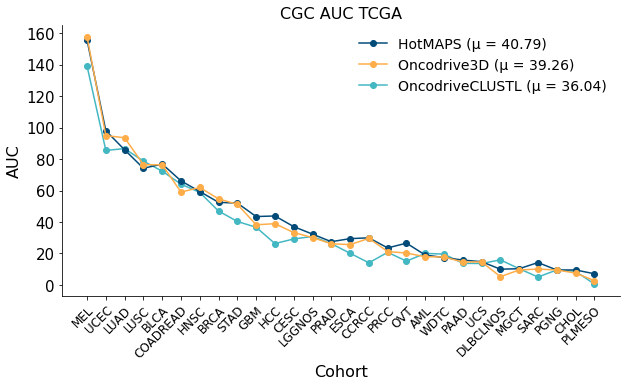

In [15]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, 
                 title = "CGC AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/cgc_auc_tcga_clust.png")

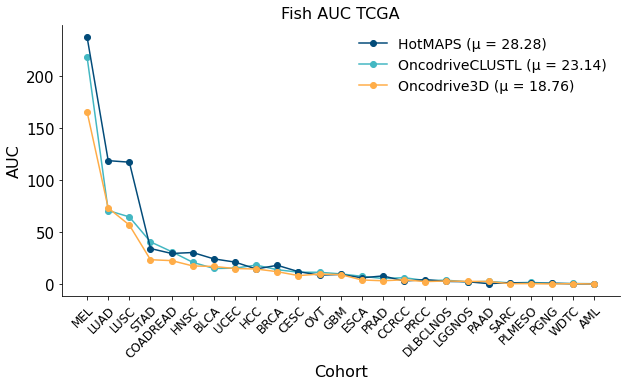

In [16]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, 
                 title = "Fish AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/fishy_auc_tcga_clust.png")

In [17]:
# All cohorts
df_auc = get_auc_genetable(genetable, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 195/195 [00:00<00:00, 310.01it/s]


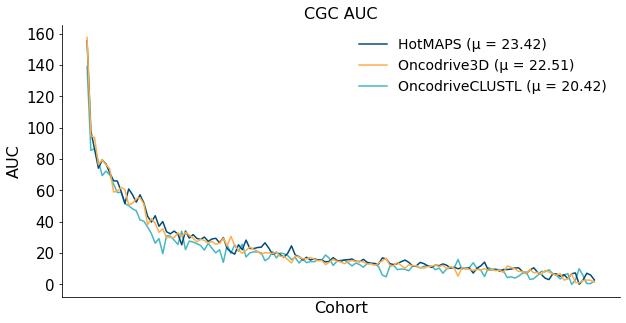

In [18]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, title = "CGC AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/cgc_auc_clust.png")

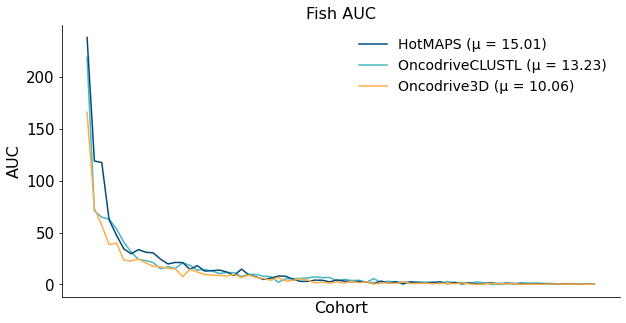

In [19]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, title = "Fish AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/fishy_auc_clust.png")

#### All methods

In [20]:
# All methods
# ===========

# lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "seismic", "dndscv", "mutpan", "fml", "random"]
lst_methods = ["o3d", "hotmaps", "clustl", "smreg", "cbase", "dndscv", "mutpan", "fml"]

# Subset cohorts
df_auc = get_auc_genetable(genetable_subset, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:00<00:00, 116.88it/s]


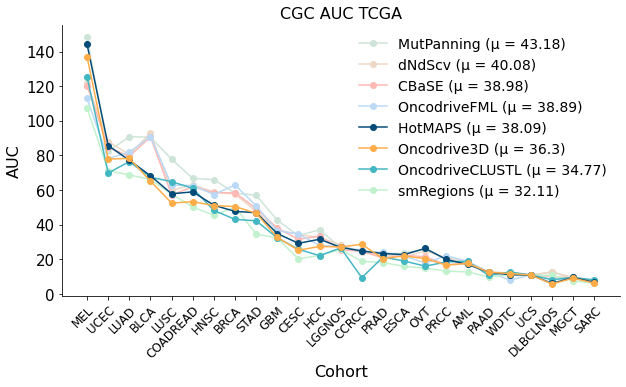

In [21]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, 
                 title = "CGC AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/cgc_auc.png")

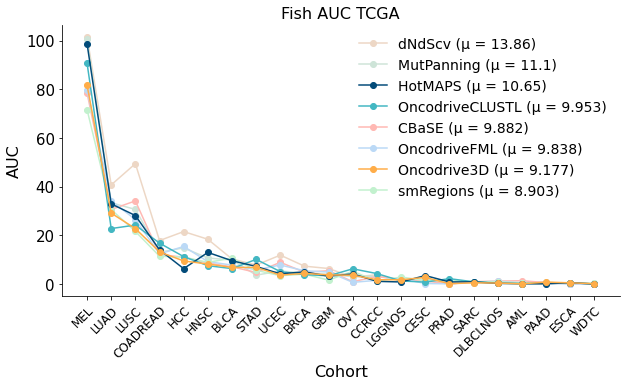

In [22]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, 
                 title = "Fish AUC TCGA", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, plot_xticks = True, 
                 extract_cancer=True, legend_outside=True, 
                 filename="plots/fishy_auc.png")

In [23]:
# All cohorts
df_auc = get_auc_genetable(genetable, 
                           lst_methods,
                           normalize=False, 
                           genes_overlap=True, 
                           min_rank_cut_thld=5,
                           processed_thld=1)

df_auc_cgc = df_auc[cols_to_plot(lst_methods, "CGC")]
df_auc_cgc = df_auc_cgc[~df_auc_cgc.isna().any(1)]
df_auc_fish = df_auc[cols_to_plot(lst_methods, "Fish")]
df_auc_fish = df_auc_fish[~df_auc_fish.isna().any(1)]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [00:00<00:00, 155.01it/s]


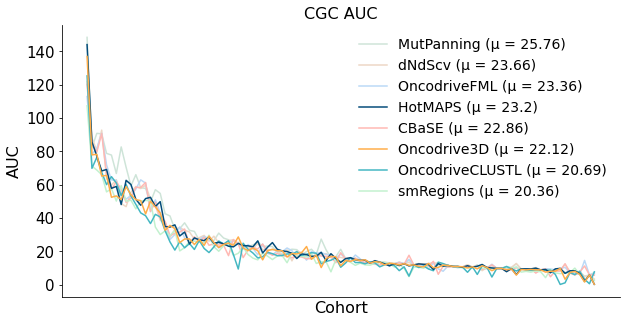

In [24]:
plot_auc_summary(df_auc_cgc, names_dict, colors_dict, title = "CGC AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/cgc_auc.png")

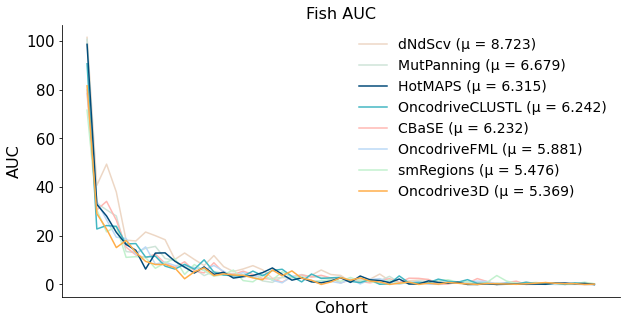

In [25]:
plot_auc_summary(df_auc_fish, names_dict, colors_dict, title = "Fish AUC", smooth = False,
                 figsize = (10, 5), legend_fontsize = 14, legend_ncol = 1, 
                 plot_xticks = False, extract_cancer=False, legend_outside=True, style="-",
                 filename="plots/fishy_auc.png")

# CH

In [26]:
# genetables_path = "../data/results/ch/run_2024-11-04_13-09-49.genetable.tsv"
# df = pd.read_csv(genetables_path, sep="\t")
# df = df.rename(columns={"3dclust_pval" : "o3d_pval",
#                        "3dclust_qval" : "o3d_qval",
#                        "3dclust_rank" : "o3d_rank",
#                        "Fishy_Genes" : "Fish"})
# df = df.drop(columns=["CGC"]).rename(columns={"CH" : "CGC"})
# df

In [27]:
# # Names and colors

# colors_dic = {"Oncodrive3D" : "#ffad48", 
#               "HotMAPS" : "#024b79", 
#               "OncodriveCLUSTL" : "#43b7c2", 
#               "smRegions" : "lightgray", 
#               "CBaSE" : "lightgray", 
#               "dNdScv" : "lightgray", 
#               "MutPanning" : "lightgray", 
#               "OncodriveFML" : "lightgray",
#               "Random" : "pink"}

# names_dic = {"o3d" : "Oncodrive3D", 
#              "hotmaps" : "HotMAPS", 
#              "clustl" : "OncodriveCLUSTL", 
#              "smreg" : "smRegions", 
#              "cbase" : "CBaSE", 
#              "dndscv" : "dNdScv", 
#              "mutpan" : "MutPanning", 
#              "fml" : "OncodriveFML",
#              "random" : "Random"}

In [28]:
# lst_methods = ["o3d", "hotmaps", "clustl", "random"]
# cohort = "OTHER_WXS_CH_IMPACT_PANEL"

# genetable_cohort = df
# methods_pval_names = [f"{method}_pval" for method in lst_methods if method != "random"]

# col_pvals = [f"{method}_pval" for method in lst_methods if method != "random"]
# min_processed = min_processed_genes(genetable_cohort[col_pvals])

# not_na = genetable_cohort[methods_pval_names].notna().all(1)
# genetable_cohort = genetable_cohort[not_na]

# df_enrich = get_enrich_cohort(genetable_cohort, 
#                             lst_methods, 
#                             normalize=False, 
#                             seed=128, 
#                             min_rank_cut_thld=1, 
#                             processed_thld=1)
# df_enrich.insert(0, "Cohort", cohort)

# enrich_target = "CGC"
# lst_methods = ["o3d", "hotmaps", "clustl", "random"] 
# enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
# plot_enrich_score(df_enrich[enrich_cols], 
#                   names_dic, 
#                   colors_dic, 
#                   title = f"{enrich_target} enrichment score CH", 
#                   smooth = False,
#                   figsize = (10, 6), 
#                   legend_fontsize = 12, 
#                   legend_ncol = 1, 
#                   legend_outside=True, 
#                   style="-",
#                   #ylim=(0.5, 1.05),
#                   filename='enrichment_ch_genes_ch.png')

# enrich_target = "Fish"
# lst_methods = ["o3d", "hotmaps", "clustl", "random"]
# enrich_cols = cols_to_plot(lst_methods, enrich_target, auc=False)
# plot_enrich_score(df_enrich[enrich_cols], 
#                   names_dic, 
#                   colors_dic, 
#                   title = f"{enrich_target} enrichment score CH", 
#                   smooth = False,
#                   figsize = (10, 6), 
#                   legend_fontsize = 12, 
#                   legend_ncol = 1, 
#                   legend_outside=True, 
#                   style="-",
#                  # xlim=(0, 614),
#                   #ylim=(-0.01, 0.2),
#                   legend=True,
#                   filename='enrichment_fishy_genes_ch.png')